In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

import requests
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import linregress

# import warnings 
# warnings.filterwarnings('ignore') 

import sys
from pathlib import Path
sys.path.insert(0,str(Path(os.path.abspath('.')).parent.parent))
import library.validation.accuracy.metric as metric


In [3]:
ticket_path = Path.home()/"OneDrive-3E/Research/Solar/tickets/2024/IN3043_accuracy_factors_analysis"
results_path = os.path.join(ticket_path, "IN3136_EURAC_shared_folder/validation")
plots_path = os.path.join(ticket_path, "plots")


# Read data

## complexity

In [4]:
complexity = pd.read_csv(os.path.join(ticket_path, 'complexity.csv'), index_col=0)

In [5]:
complexity['climate_classification'] = complexity['climate_zone'].fillna('').apply(lambda word: word[0] if word else np.nan)
complexity

,country,latitude,longitude,altitude,provider,terrain_classification,tri_1km,tri_5km,tri_10km,tpi_1km,tpi_5km,tpi_10km,distance_to_coastline_km,climate_zone,clearness (%),climate_classification
station_name,,,,,,,,,,,,,,,,
camborne,United Kingdom,50.22,-5.32,88.0,bsrn,_flat plains,1.6250,2.875,2.875,0.2500,0.125,0.0,3.211302,Cfb,68.509617,C
carpentras,France,44.08,5.06,100.0,bsrn,_flat plains,1.5000,2.000,1.375,0.0000,0.000,0.0,57.987479,Cfb,84.703463,C
budapest_lorinc,Hungary,47.43,19.18,139.0,bsrn,_flat plains,2.1250,1.375,1.500,0.1875,0.000,0.0,482.028360,Cfb,73.573263,C
magurele_mars,Romania,44.34,26.01,110.0,bsrn,_flat plains,0.8125,0.750,0.875,0.0000,0.000,0.0,198.059538,Cfa,76.351207,C
cabauw,Netherlands,51.97,4.93,0.0,bsrn,_flat plains,0.7500,0.500,0.500,0.0625,0.000,0.0,49.955084,Cfb,70.044037,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dublin_arpt,Ireland,53.43,-6.23,82.0,wrdc,_flat plains,1.5000,1.250,1.125,-0.1250,0.125,0.0,4.175609,Cfb,64.296802,C
grossenzersdorf,Austria,48.20,16.57,157.0,wrdc,_flat plains,1.0000,1.125,1.125,0.0625,0.000,0.0,357.351298,Cfb,71.090746,C
gonzaga,Italy,44.96,10.77,16.0,lombardy,_flat plains,0.8750,1.125,1.000,0.0000,0.000,0.0,117.377329,Cfa,78.808519,C


In [21]:
complexity.to_csv(os.path.join(ticket_path, 'complexity.csv'))

## validation

In [6]:
validation_metrics = pd.read_csv(os.path.join(results_path, "validation_metrics.csv"), index_col = 0)

In [7]:
validation_metrics = validation_metrics.drop(['valid_data_pairs_daily', 'valid_data_pairs_hourly'], axis=1)
validation_metrics.index.name = 'station_name'

validation_metrics

,nmbe,nrmse_yearly,nrmse_monthly,nrmse_daily,nrmse_hourly
station_name,,,,,
camborne,-1.713271,2.390578,2.960226,20.515307,19.891331
carpentras,-0.667623,0.908728,2.305455,11.637070,11.227009
budapest_lorinc,-0.438789,0.516789,2.504264,15.510051,15.026375
magurele_mars,-0.241528,0.241528,2.793683,13.151986,12.704396
cabauw,-0.199198,0.609549,2.155886,16.649853,16.077524
...,...,...,...,...,...
dublin_arpt,3.362028,3.494330,5.239870,9.972663,NaN
grossenzersdorf,5.926388,6.072439,6.855718,9.840883,NaN
gonzaga,-6.679113,6.724571,7.997686,38.823848,16.058042


In [8]:
metric_list = ['nmbe', 'nrmse_hourly', 'nrmse_daily']

In [28]:
continuous_list = ['tri_1km','tri_5km','tri_10km','tpi_1km','tpi_5km','tpi_10km','distance_to_coastline_km','clearness (%)']
categorical_list = ['terrain_classification', 'climate_zone']

# Descriptive statistics

In [13]:
terrain_sta = []

for class_name in complexity['terrain_classification'].unique():
    if not pd.isnull(class_name):
        for metric_name in validation_metrics.columns:
            data = complexity[complexity['terrain_classification'] == class_name]
            var_name = f'{metric_name}{class_name.replace(" ", "_")}'
            var_value = validation_metrics.loc[data.index, metric_name]
            var_stat = var_value.describe()
            var_df = pd.DataFrame(var_stat)
            var_df.columns = [var_name] 
            terrain_sta.append(var_df)


In [14]:
terrain_sta_combined = pd.concat(terrain_sta, axis=1).transpose()
terrain_sta_combined

,count,mean,std,min,25%,50%,75%,max
nmbe_flat_plains,41.0,2.773903,12.177092,-6.679113,-0.454500,0.595488,2.352328,76.872887
nrmse_yearly_flat_plains,41.0,5.281690,17.459029,0.241528,1.363417,1.962824,2.865808,113.205374
nrmse_monthly_flat_plains,41.0,7.700813,20.813506,1.726415,2.799792,3.295136,4.533917,135.449842
nrmse_daily_flat_plains,41.0,21.052169,27.468222,5.431103,8.094997,10.675065,20.515307,170.852566
nrmse_hourly_flat_plains,18.0,17.568694,4.165529,11.227009,16.062912,17.170444,19.308335,30.732195
nmbe_irregular_plains,15.0,1.992218,1.956011,-1.529291,0.685802,2.363163,3.416212,5.062539
nrmse_yearly_irregular_plains,15.0,2.740481,1.725791,0.607400,1.349997,2.628755,3.644485,6.180319
nrmse_monthly_irregular_plains,15.0,4.810307,3.144582,1.964176,2.689904,4.543274,5.141396,14.219644
nrmse_daily_irregular_plains,15.0,22.338619,17.470418,5.257688,8.047530,9.525499,40.434086,48.730371
nrmse_hourly_irregular_plains,7.0,17.383162,2.549810,15.239666,15.912793,17.043246,17.358271,22.857096


In [29]:
climate_sta = []

for class_name in complexity['climate_zone'].unique():
    if not pd.isnull(class_name):
        for metric_name in validation_metrics.columns:
            data = complexity[complexity['climate_zone'] == class_name]
            var_name = f'{metric_name}_{class_name.replace(" ", "_")}'
            var_value = validation_metrics.loc[data.index, metric_name]
            var_stat = var_value.describe()
            var_df = pd.DataFrame(var_stat)
            var_df.columns = [var_name] 
            climate_sta.append(var_df)


In [30]:
climate_sta_combined = pd.concat(climate_sta, axis=1).transpose()
climate_sta_combined

,count,mean,std,min,25%,50%,75%,max
nmbe_Cfb,54.0,2.662706,10.515738,-5.522931,-0.223875,1.473251,2.773558,76.872887
nrmse_yearly_Cfb,54.0,4.562759,15.159254,0.462383,1.300808,2.239750,3.391635,113.205374
nrmse_monthly_Cfb,54.0,6.770082,18.130991,1.726415,2.878587,3.549679,4.557634,135.449842
nrmse_daily_Cfb,54.0,22.199019,25.263291,6.653321,8.241412,10.980499,39.701514,170.852566
nrmse_hourly_Cfb,25.0,17.581102,2.315719,11.227009,16.138819,17.305384,19.515762,22.857096
nmbe_Cfa,7.0,1.437750,5.313712,-6.679113,-0.155491,0.595488,2.677341,11.104173
nrmse_yearly_Cfa,7.0,4.217810,4.825918,0.241528,1.057229,2.520295,5.353723,13.940949
nrmse_monthly_Cfa,7.0,7.053134,4.988730,2.353924,3.001840,6.965473,8.849968,16.348921
nrmse_daily_Cfa,7.0,25.202006,15.737007,7.157092,14.021394,16.736011,38.880690,46.716771
nrmse_hourly_Cfa,4.0,18.122010,8.542635,12.704396,12.921154,14.525724,19.726580,30.732195


## Bar chart

In [98]:
groups = ['Temperate', 'Continental']

average_nmbe = [average_nmbe_c, average_nmbe_d]
average_nrmse_hou = [average_nrmse_hou_c, average_nrmse_hou_d]
average_nrmse_dai = [average_nrmse_dai_c, average_nrmse_dai_d]
average_nrmse_mon = [average_nrmse_mon_c, average_nrmse_mon_d]
average_nrmse_yea = [average_nrmse_yea_c, average_nrmse_yea_d]


In [99]:
for metric_list in [average_nmbe, average_nrmse_hou, average_nrmse_dai, average_nrmse_mon, average_nrmse_yea]:
    for i in range(len(metric_list)):
        if np.isnan(metric_list[i]).all():
            metric_list[i] = 0

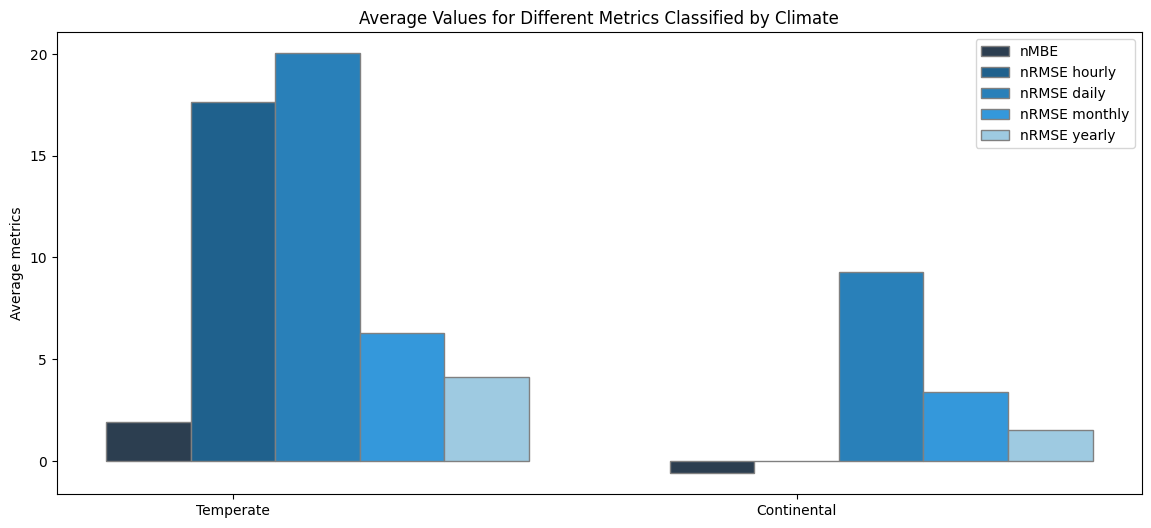

In [100]:
bar_width = 0.15
r1 = np.arange(len(groups))
r2 = [x + bar_width for x in r1]
r3 = [x + 2 * bar_width for x in r1]
r4 = [x + 3 * bar_width for x in r1]
r5 = [x + 4 * bar_width for x in r1]

plt.figure(figsize=(14,6))

plt.bar(r1, average_nmbe, color='#2c3e50', width=bar_width, edgecolor='grey', label='nMBE')
plt.bar(r2, average_nrmse_hou, color='#1f618d', width=bar_width, edgecolor='grey', label='nRMSE hourly')
plt.bar(r3, average_nrmse_dai, color='#2980b9', width=bar_width, edgecolor='grey', label='nRMSE daily')
plt.bar(r4, average_nrmse_mon, color='#3498db', width=bar_width, edgecolor='grey', label='nRMSE monthly')
plt.bar(r5, average_nrmse_yea, color='#9ecae1', width=bar_width, edgecolor='grey', label='nRMSE yearly')

plt.ylabel('Average metrics')
plt.title('Average Values for Different Metrics Classified by Climate')
plt.xticks([x + bar_width for x in r1], groups)
plt.legend()

plt.savefig(os.path.join(plots_path, 'climate_zones/average_metrics.png'), dpi=300)

plt.show()


In [34]:
continents = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Zealandia']
counts = [86, 39, 27, 95, 3, 1]


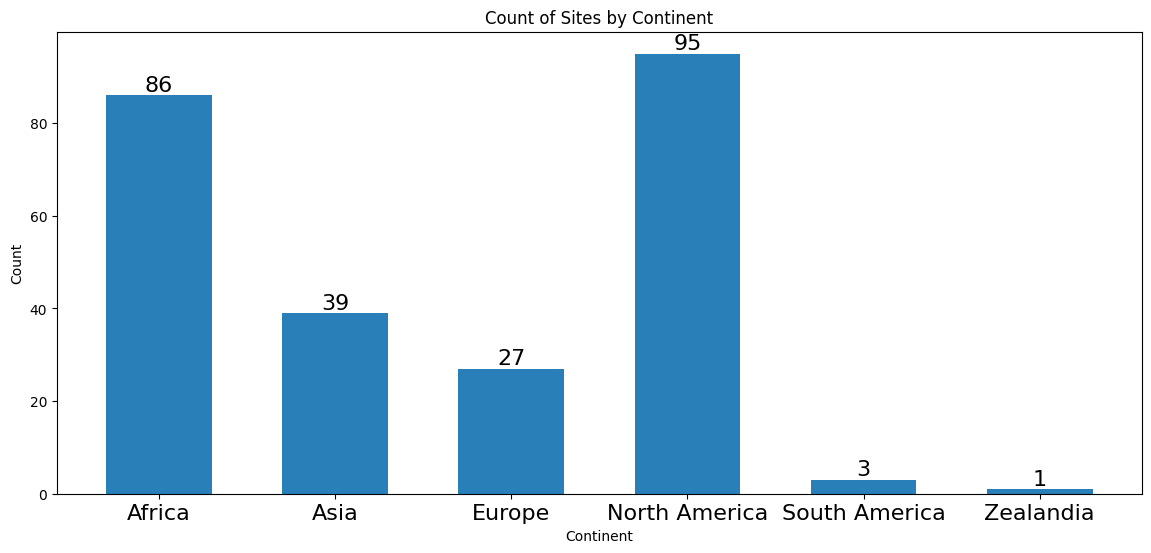

In [46]:
fig, ax = plt.subplots(figsize=(14,6))

# Create a bar chart
bars = ax.bar(continents, counts, color='#2980b9', width=0.6)

# Add labels on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', fontsize=16)

# Set labels and title
ax.set_xlabel('Continent')
ax.set_ylabel('Count')
ax.set_title('Count of Sites by Continent')

plt.tick_params(axis='x', labelsize = 16)

plt.show()


In [93]:
terrain_labels = ['flat_plains', 'irregular_plains', 'smooth_low_hills', 'rough_low_hills', 'tablelands', 'high_hills', 'low_mountains']
counts_time1 = [41,15,12,1,2,4,1]
counts_time2 = [18,7,2,0,0,1,0]

In [94]:
colors = ['#9ecae1','#3498db','#2980b9','#1f618d', '#f5b7b1', '#e74c3c', '#c0392b', '#922b21']

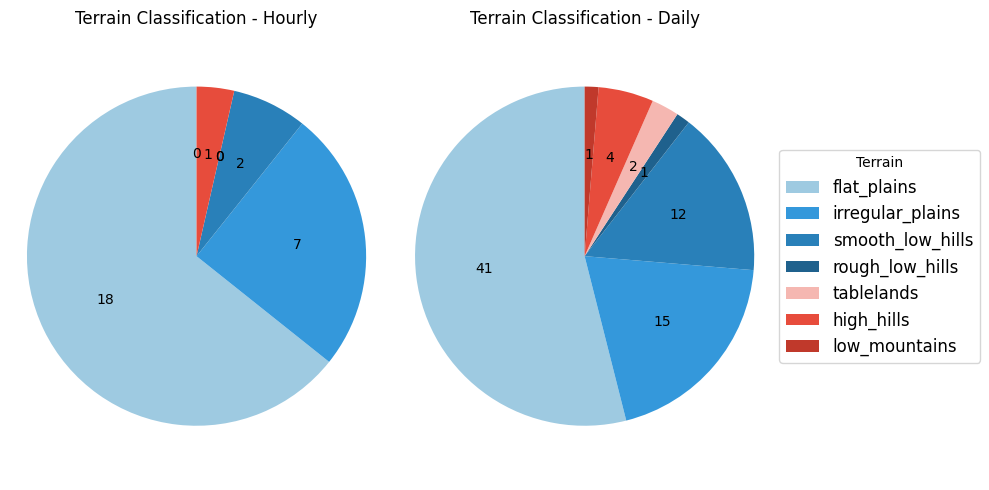

In [95]:

# Create subplots for side-by-side pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Second Pie Chart (for time2)
wedges2, texts2, autotexts2 = ax1.pie(counts_time2, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')
ax1.set_title('Terrain Classification - Hourly')

# First Pie Chart (for time1)
wedges1, texts1, autotexts1 = ax2.pie(counts_time1, autopct='%1.1f%%', startangle=90, colors=colors)
ax2.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle
ax2.set_title('Terrain Classification - Daily')


# Create a legend
ax2.legend(wedges1, terrain_labels, title="Terrain", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)

# Hide labels on the pie charts
for text in texts1 + texts2:
    text.set_visible(False)

# Show the count numbers on the pie charts
for autotext, count in zip(autotexts1 + autotexts2, counts_time1 + counts_time2):
    autotext.set_visible(True)
    autotext.set_text(f'{count}')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()


In [78]:
climate_labels = ['Cold semi-arid climate (Bsk)', 'Humid subtropical climate (Cfa)', 'Temperate oceanic climate or subtropical highland climate (Cfb)', 'Subpolar oceanic climate (Cfc)', 'Hot-summer Mediterranean climate (Csa)', 'Warm-summer Mediterranean climate (Csb)', 'Warm-summer humid continental climate (Dfb)']
counts_time1 = [2,7,54,1,8,4,3]
counts_time2 = [0,4,25,0,0,0,0]

In [85]:
colors = ['#f5b7b1','#9ecae1','#3498db','#2980b9','#1f618d', '#2c3e50', '#27ae60']


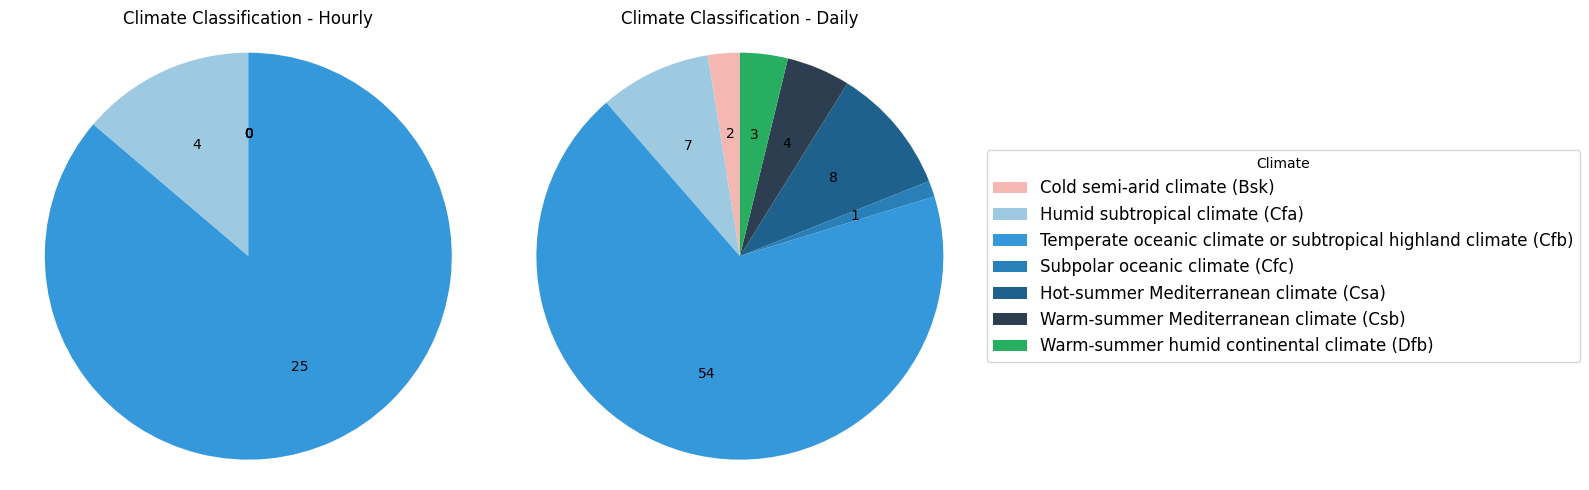

In [92]:

# Create subplots for side-by-side pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Second Pie Chart (for time2)
wedges2, texts2, autotexts2 = ax1.pie(counts_time2, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')
ax1.set_title('Climate Classification - Hourly')

# First Pie Chart (for time1)
wedges1, texts1, autotexts1 = ax2.pie(counts_time1, autopct='%1.1f%%', startangle=90, colors=colors)
ax2.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle
ax2.set_title('Climate Classification - Daily')


# Create a legend
ax2.legend(wedges1, climate_labels, title="Climate", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)

# Hide labels on the pie charts
for text in texts1 + texts2:
    text.set_visible(False)

# Show the count numbers on the pie charts
for autotext, count in zip(autotexts1 + autotexts2, counts_time1 + counts_time2):
    autotext.set_visible(True)
    autotext.set_text(f'{count}')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()


# Scatter plot

In [23]:
def continuous_scatter(df_complexity, df_validation, complexity_name, metric_name):
    # merge df
    merged_df = pd.merge(df_complexity, df_validation, on='station_name')
    
    # outlier
    ## detect
    z_scores = (merged_df[metric_name] - merged_df[metric_name].mean()) / merged_df[metric_name].std()
    outlier_indices = merged_df[z_scores >= 3].index
    print("Indices of outliers:", outlier_indices)
    
    ## delete
    merged_df = merged_df[(z_scores < 3)]
    
    # plot
    plt.figure(figsize=(12, 6))
    plt.scatter(merged_df[complexity_name], merged_df[metric_name])

    ## Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(merged_df[complexity_name], merged_df[metric_name])
    x_values = np.array([merged_df[complexity_name].min(), merged_df[complexity_name].max()])
    y_values = slope * x_values + intercept

    ## Plot the regression line
    plt.plot(x_values, y_values, color='red', label='Linear Regression')

    plt.title(f'Correlation between {complexity_name} and {metric_name}', fontsize = 24)
    plt.xlabel(complexity_name, fontsize = 24)
    plt.ylabel(metric_name, fontsize = 24)
    plt.tick_params(axis='x', labelsize = 24)
    plt.tick_params(axis='y', labelsize = 24)    

    plt.legend()
    plt.grid(True)
    
    # plt.savefig(os.path.join(plots_path, f'{complexity_name}_{metric_name}.png'), dpi=300)

    plt.show()

In [54]:
def continuous_scatter(df_complexity, df_validation, complexity_name, metric_name):
    # merge df
    merged_df = pd.merge(df_complexity, df_validation, on='station_name')
    
    # outlier
    ## detect
    z_scores = (merged_df[metric_name] - merged_df[metric_name].mean()) / merged_df[metric_name].std()
    outlier_indices = merged_df[z_scores >= 3].index
    print("Indices of outliers:", outlier_indices)
    
    ## delete
    merged_df = merged_df[(z_scores < 3)]
    
    # plot
    plt.figure(figsize=(12, 6))
    plt.scatter(merged_df[complexity_name], merged_df[metric_name])

    ## Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(merged_df[complexity_name], merged_df[metric_name])
    x_values = np.array([merged_df[complexity_name].min(), merged_df[complexity_name].max()])
    y_values = slope * x_values + intercept

    ## Plot the regression line
    plt.plot(x_values, y_values, color='red', label='Linear Regression')

    plt.title(f'Correlation between tpi and {metric_name}', fontsize = 24)
    plt.xlabel('tpi', fontsize = 24)
    plt.ylabel(metric_name, fontsize = 24)
    plt.tick_params(axis='x', labelsize = 24)
    plt.tick_params(axis='y', labelsize = 24)    

    plt.legend()
    plt.grid(True)
    
    # plt.savefig(os.path.join(plots_path, f'{complexity_name}_{metric_name}.png'), dpi=300)

    plt.show()

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


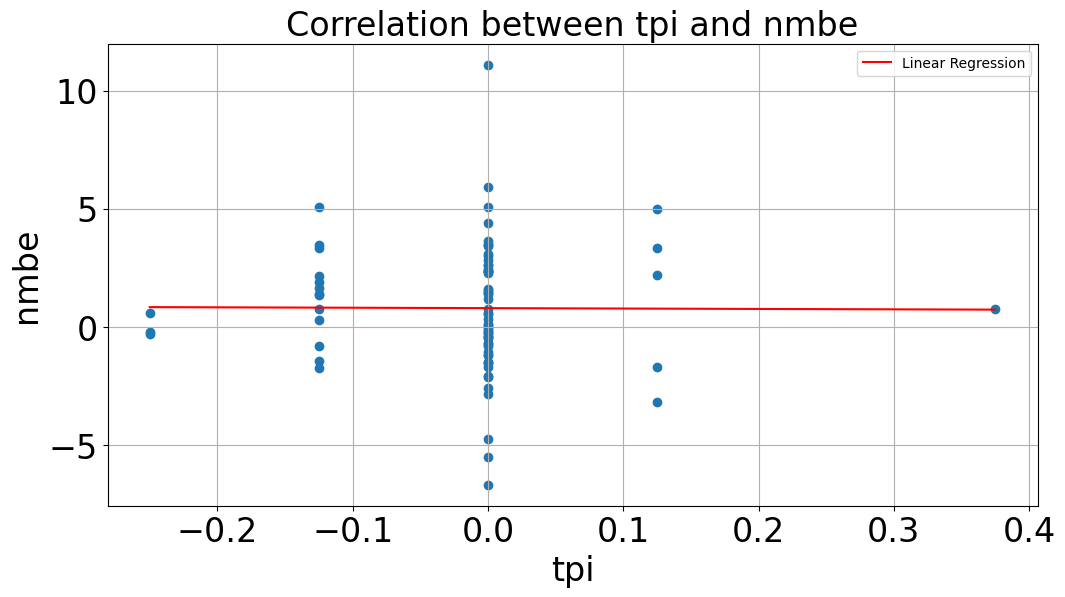

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


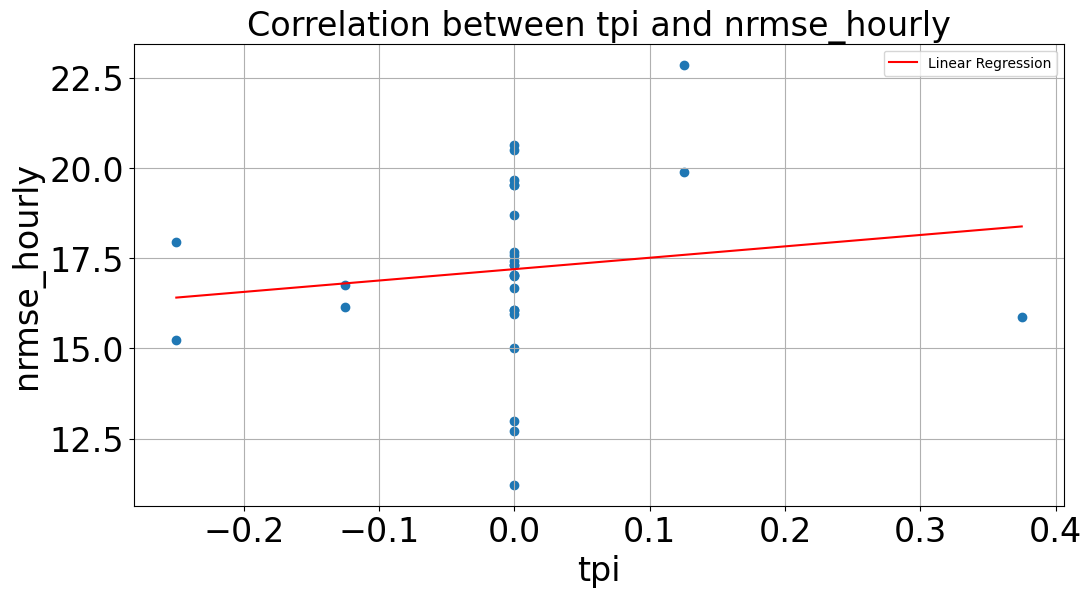

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


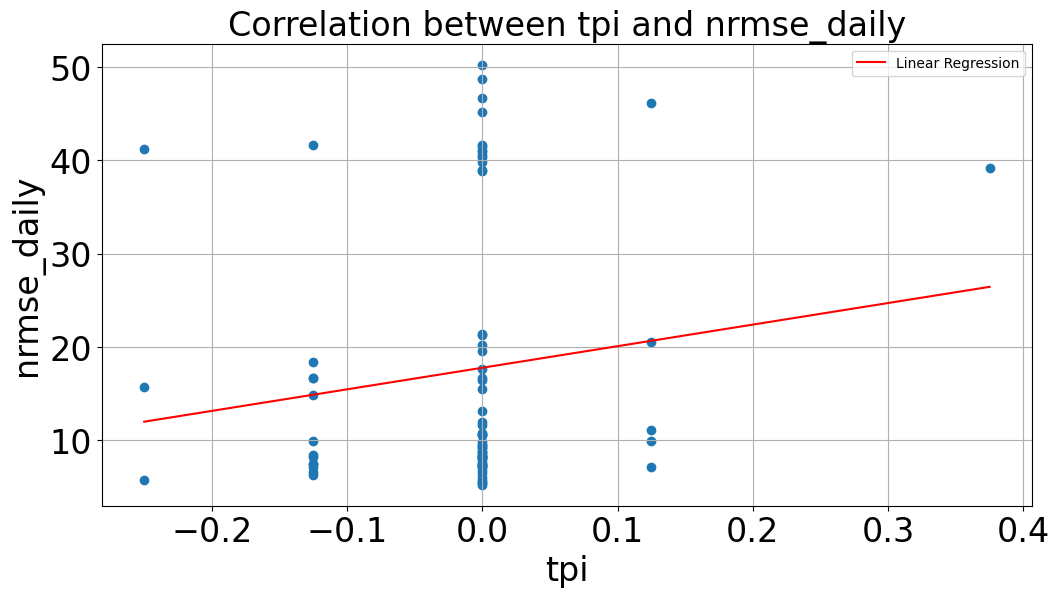

In [55]:
for metric_name in metric_list:
    continuous_scatter(complexity, validation_metrics, 'tpi_5km', metric_name)

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


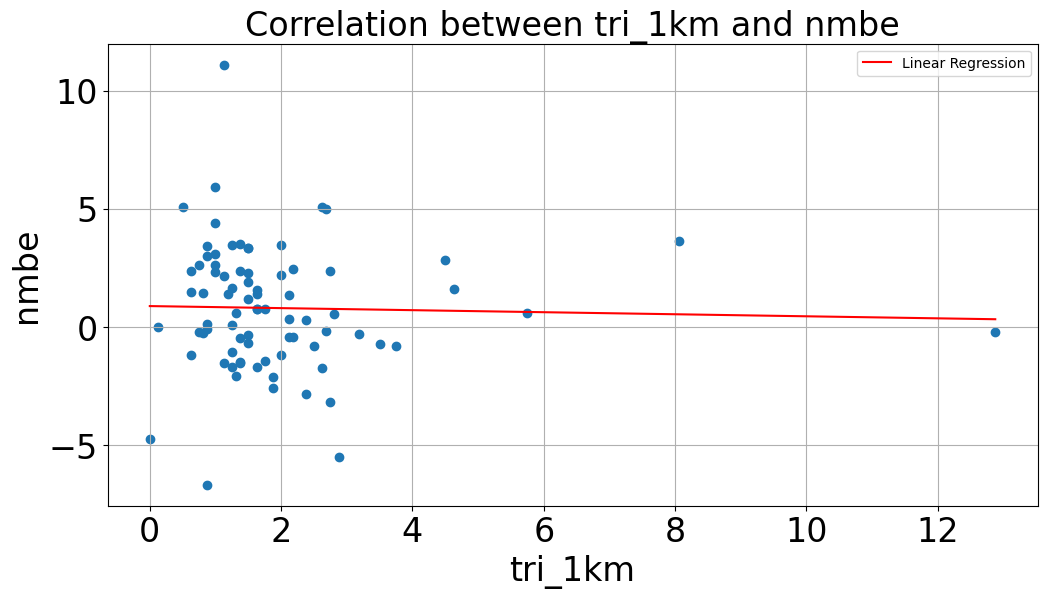

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


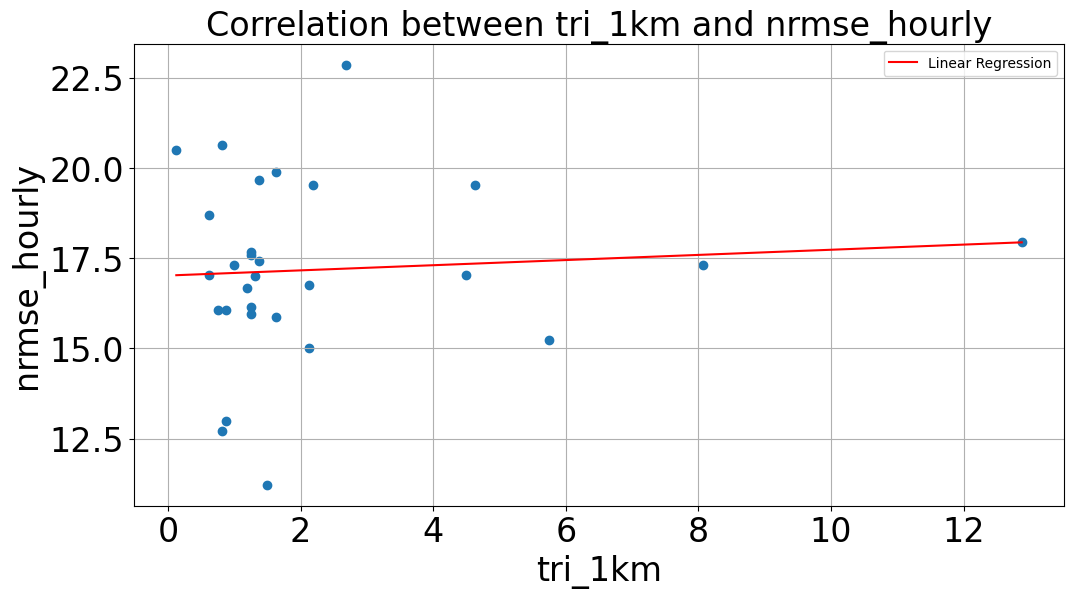

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


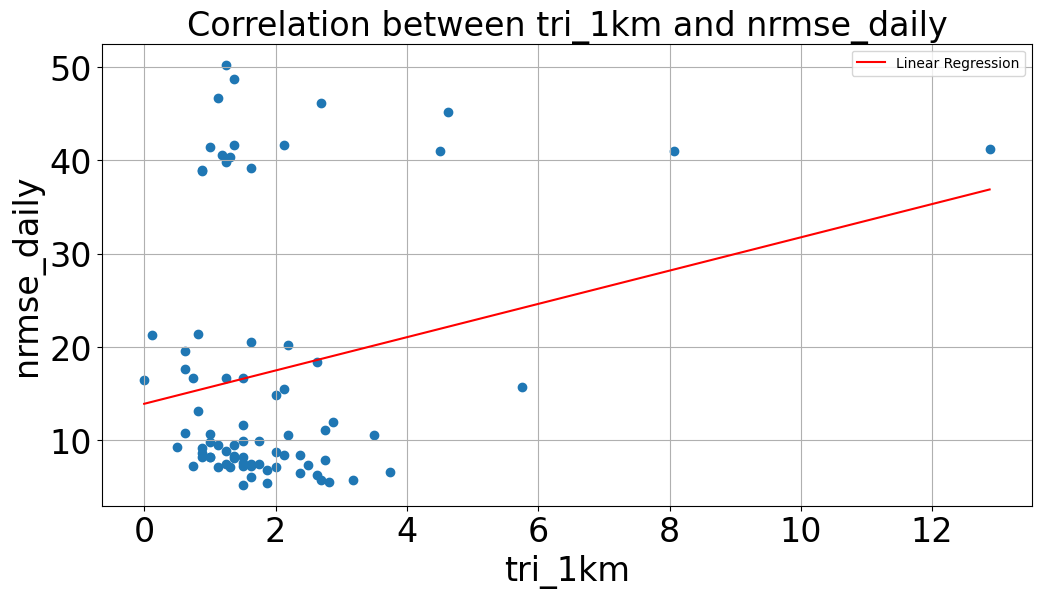

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


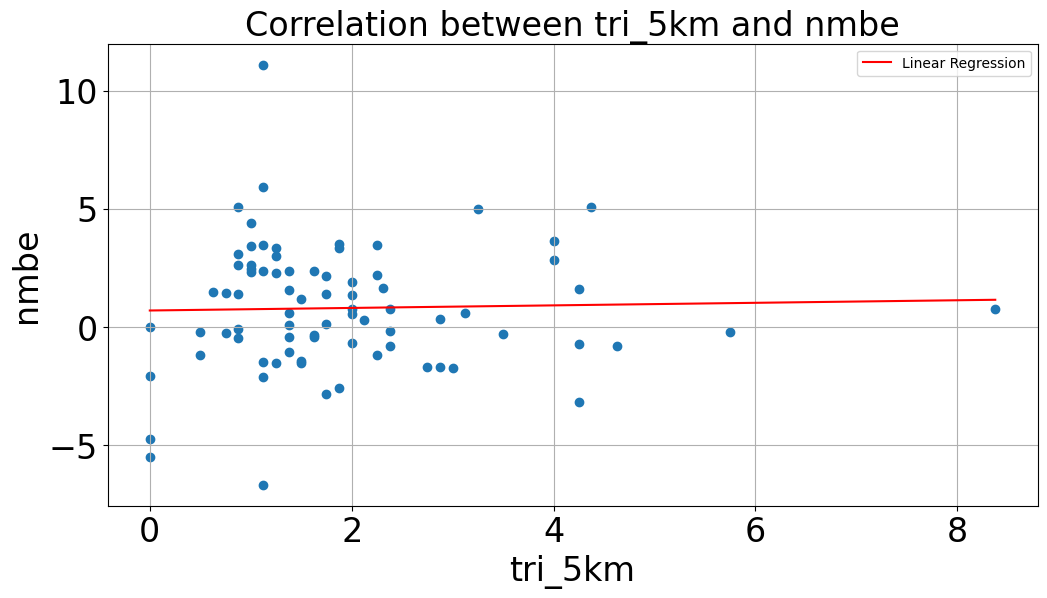

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


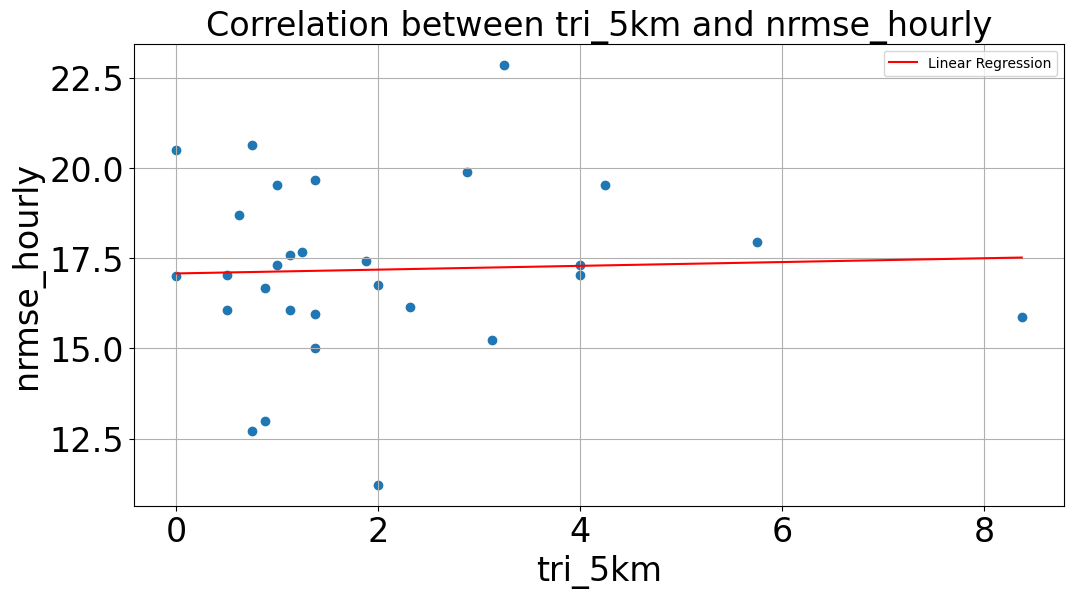

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


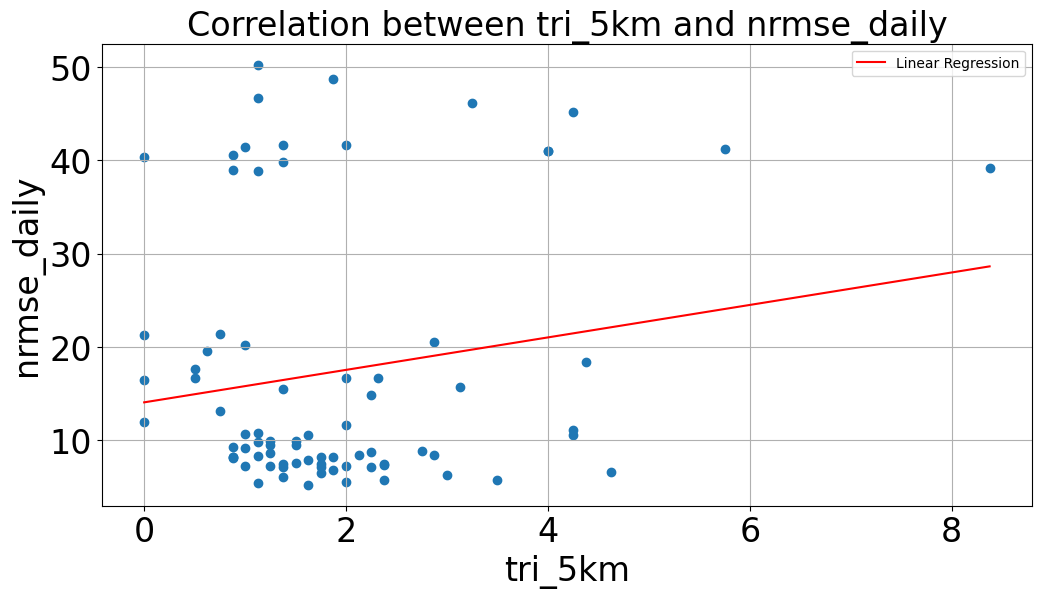

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


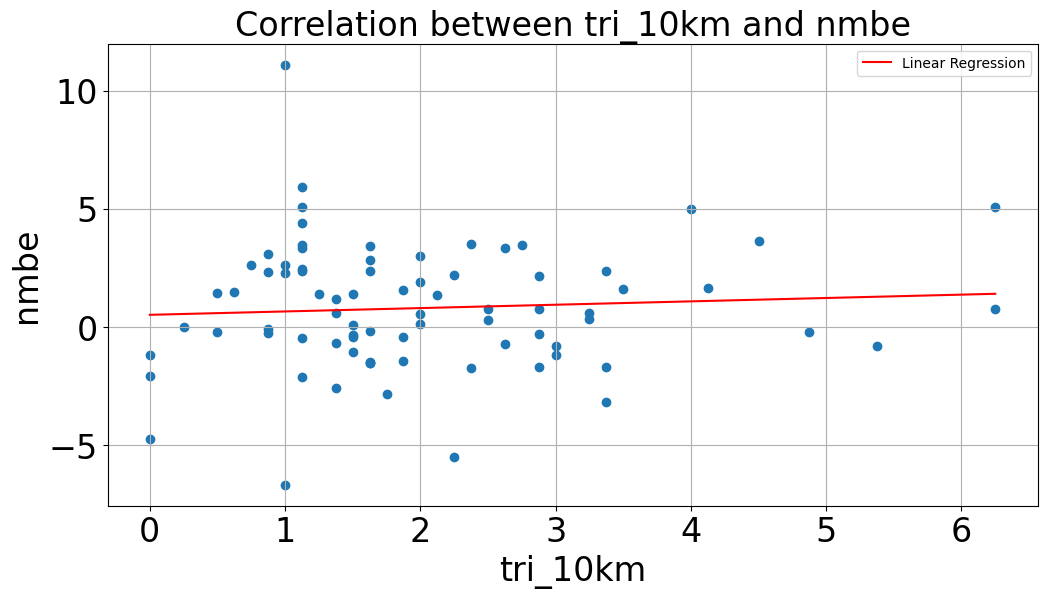

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


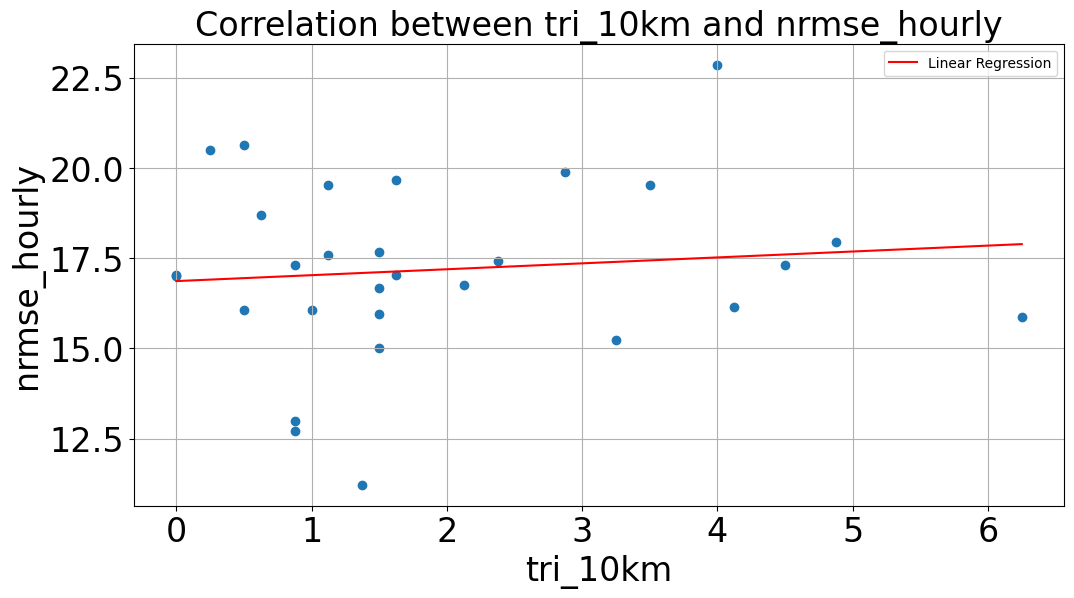

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


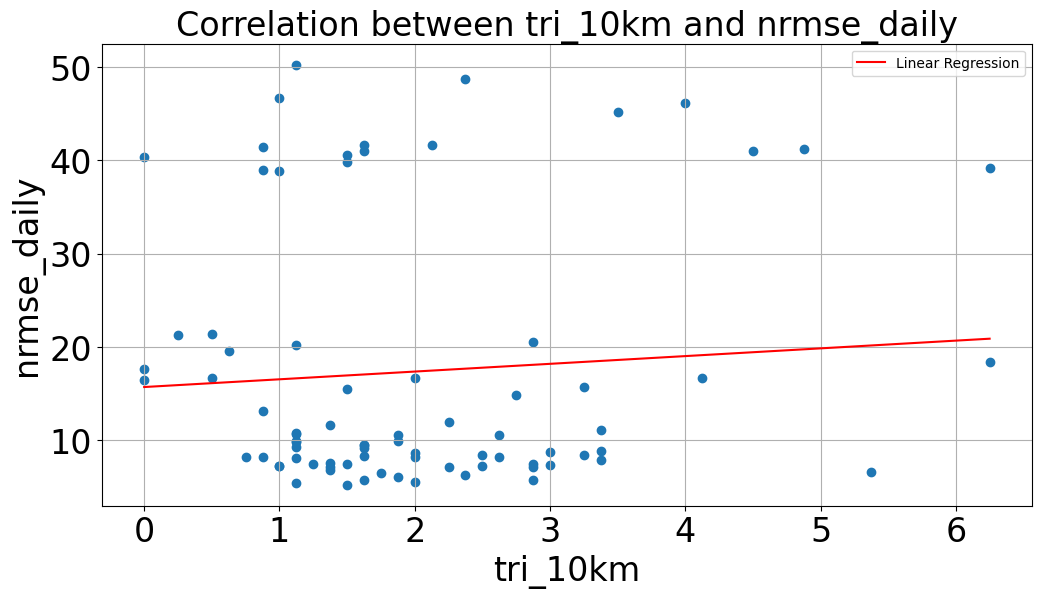

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


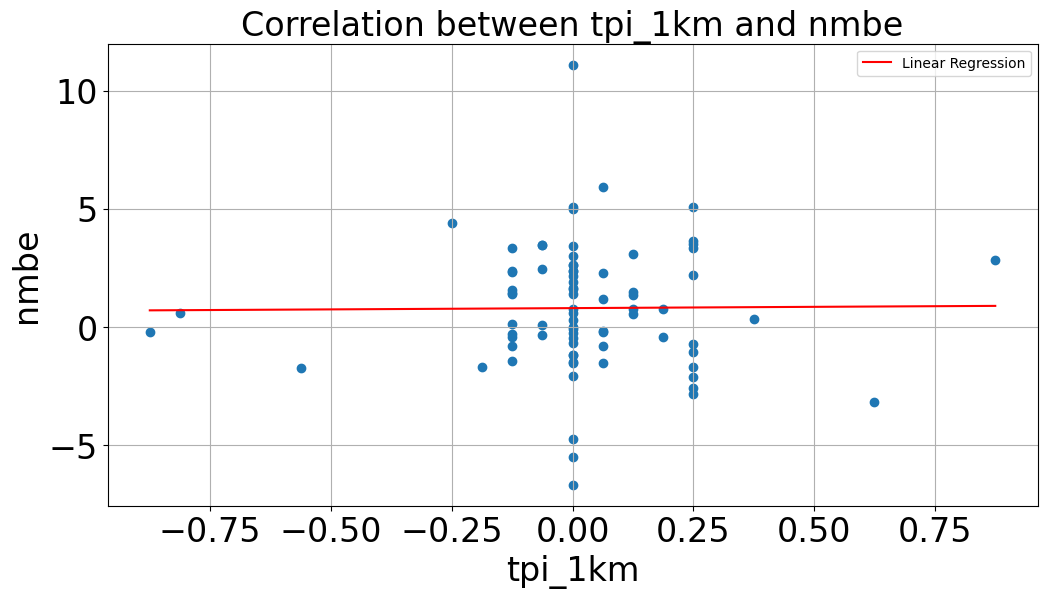

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


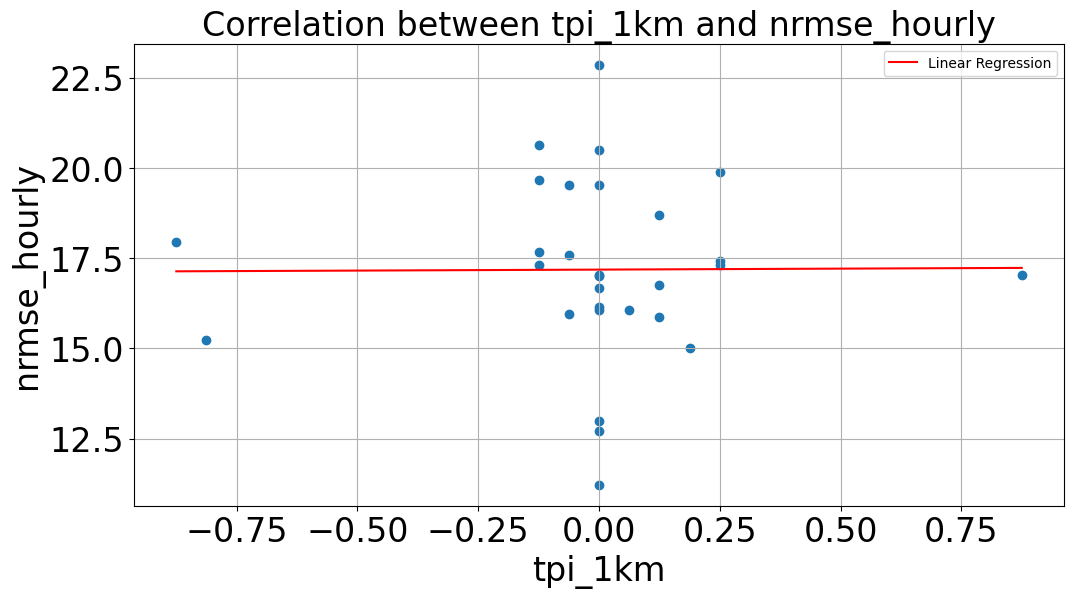

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


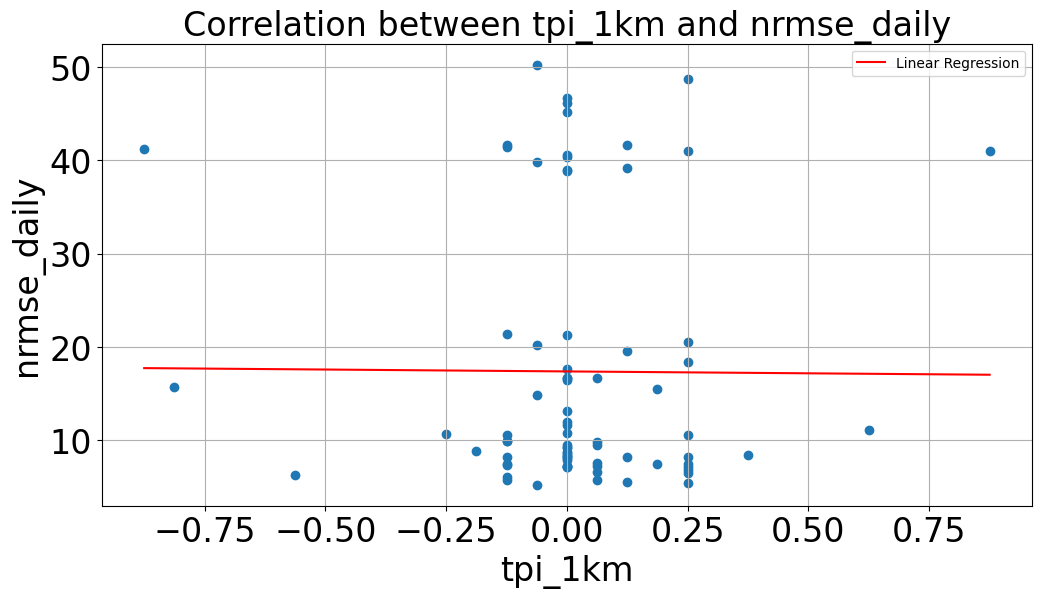

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


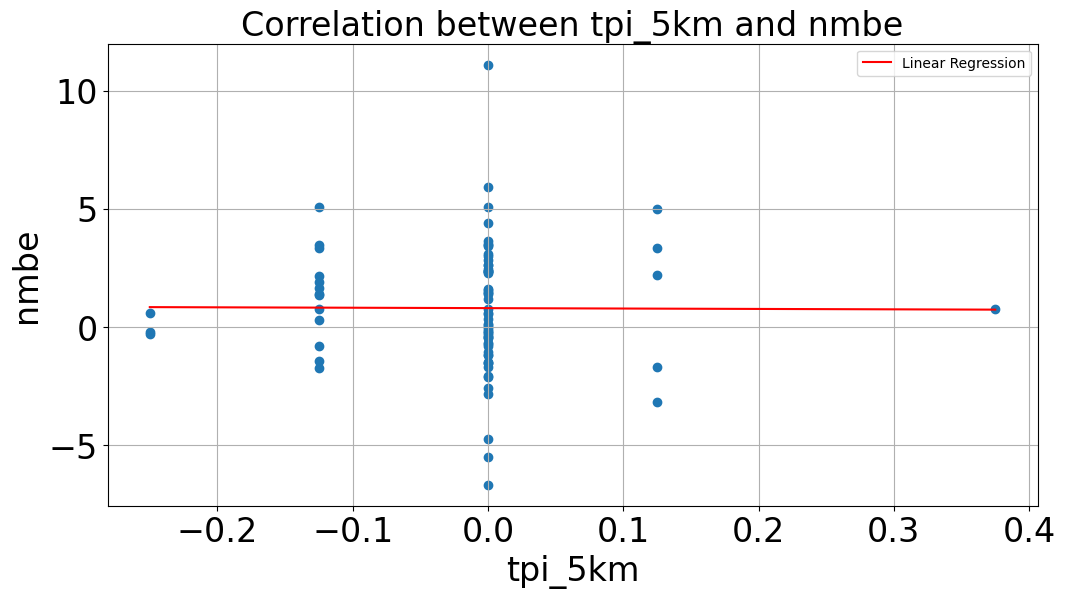

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


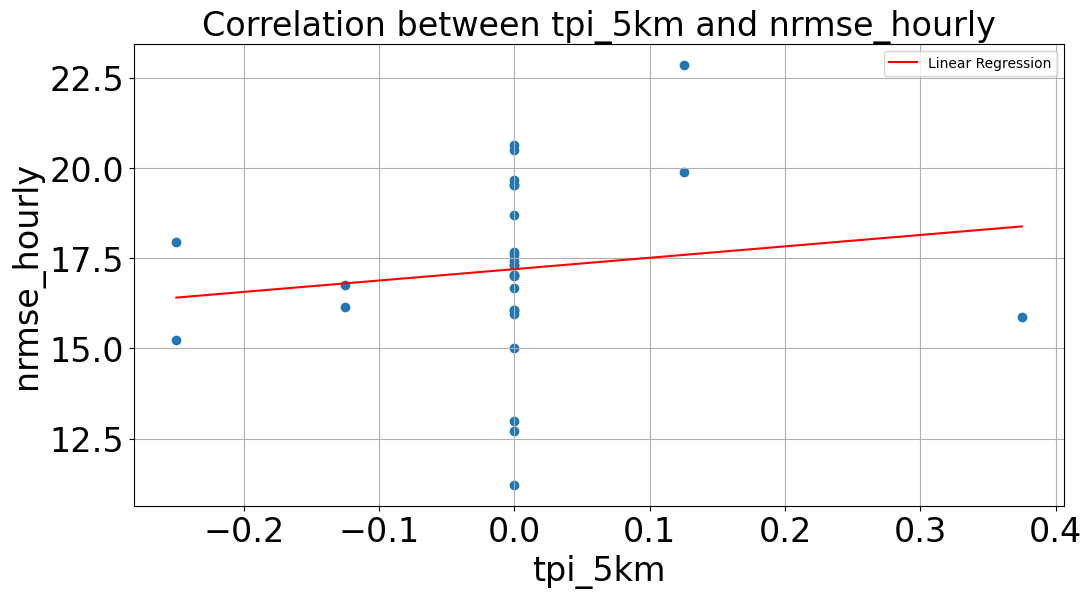

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


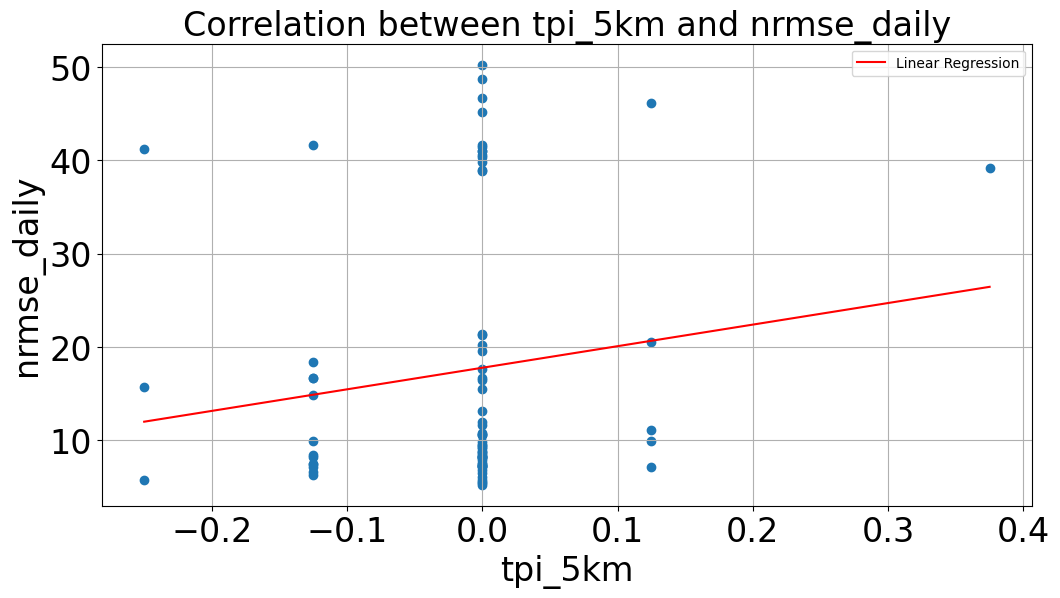

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


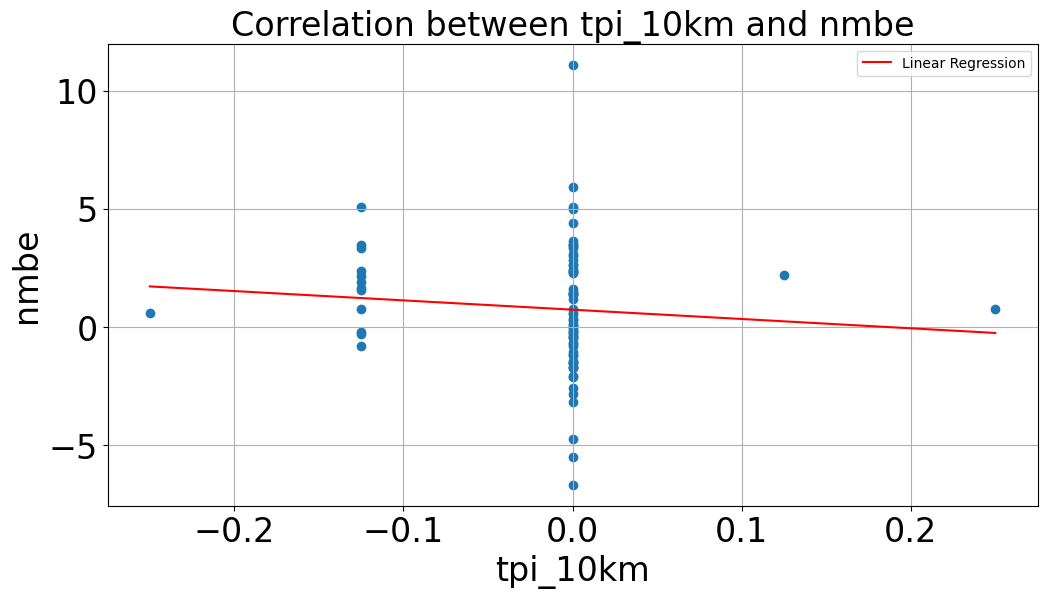

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


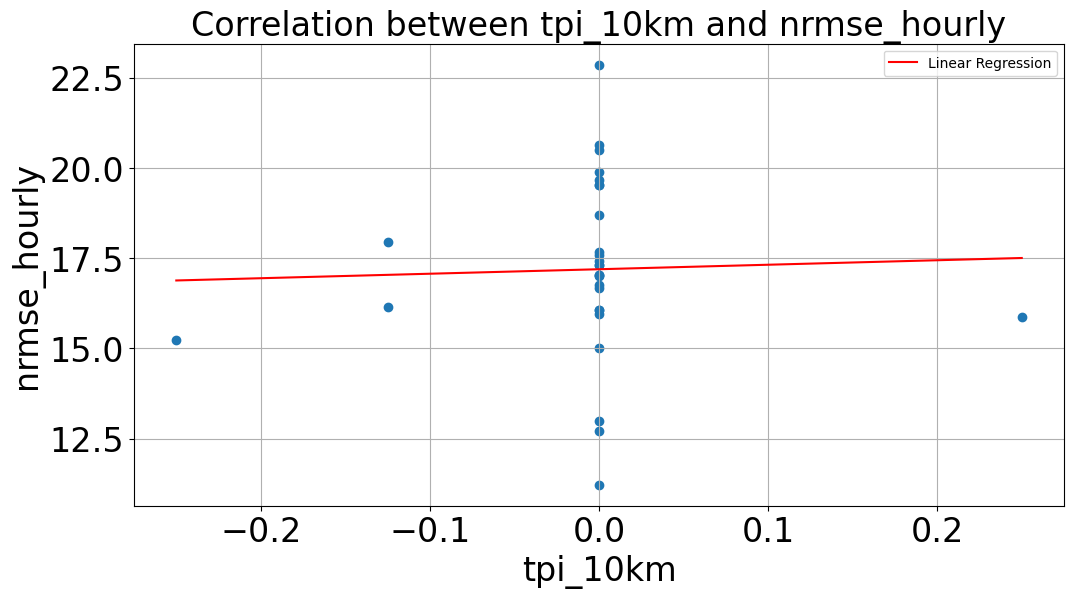

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


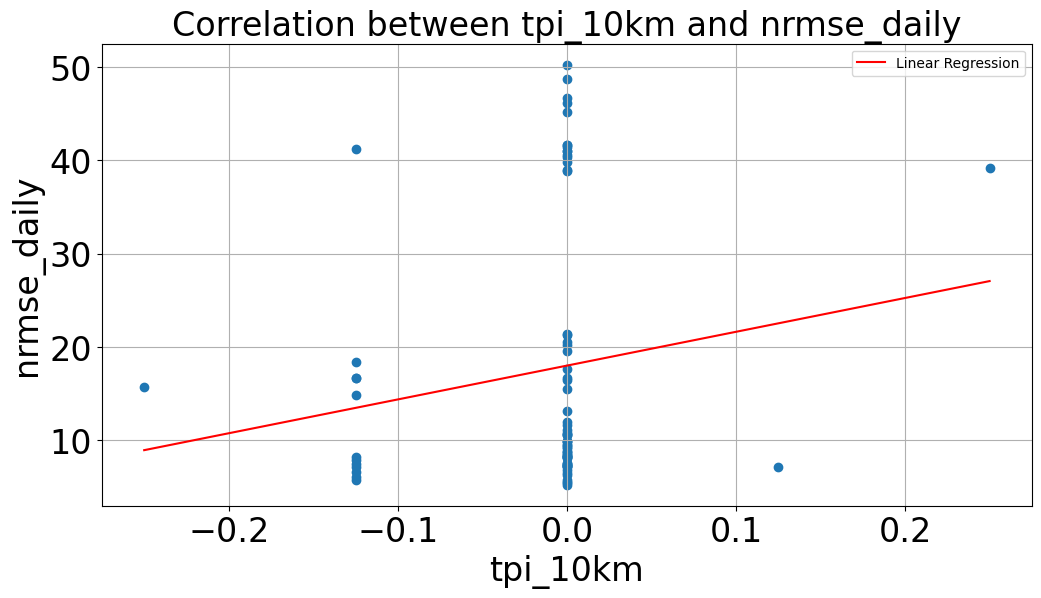

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


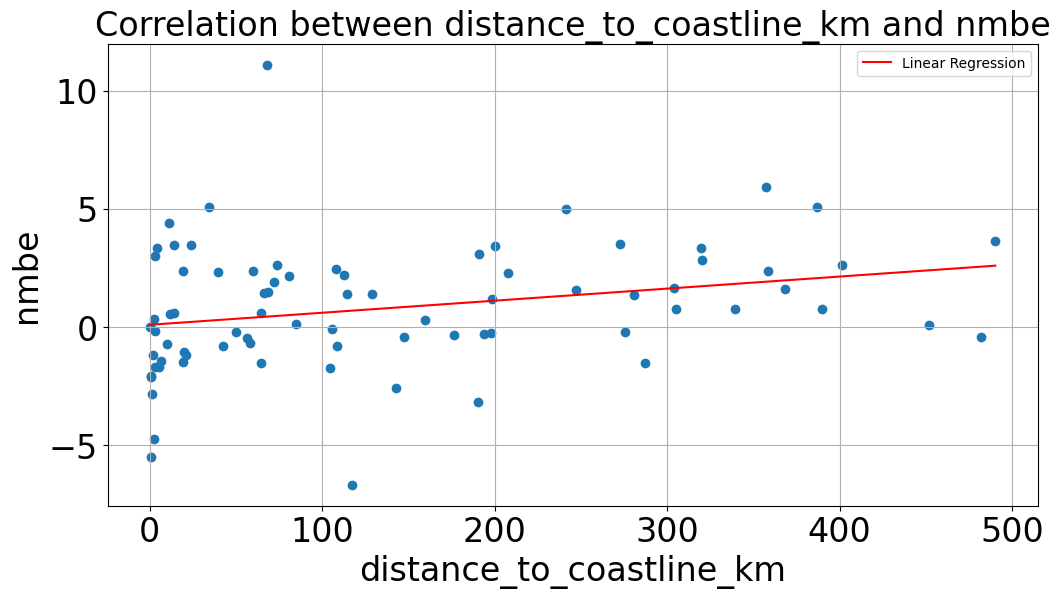

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


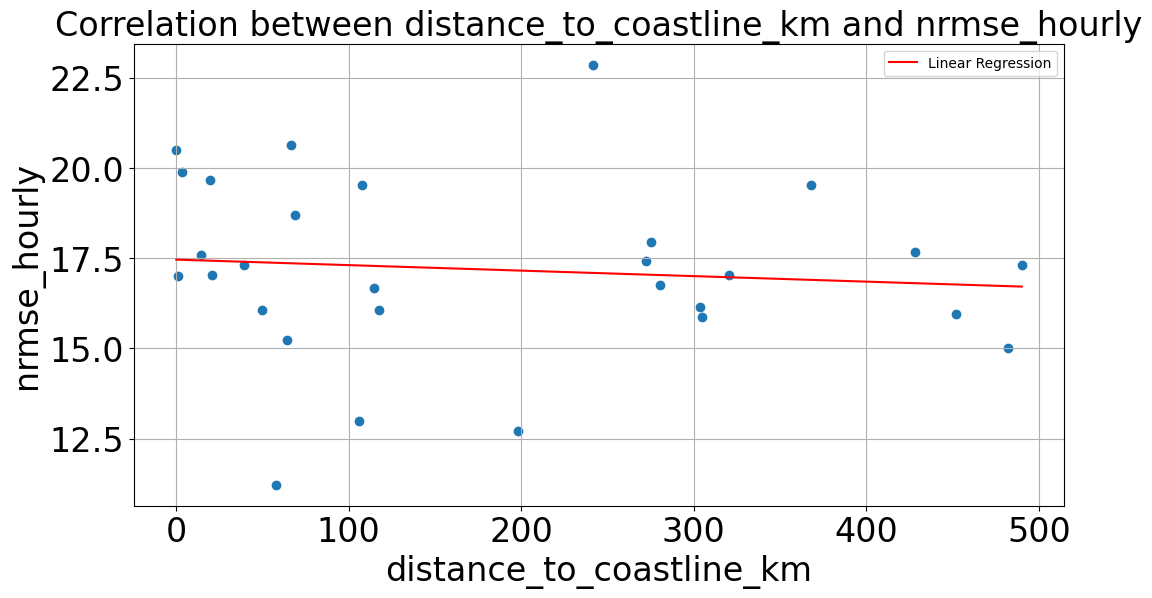

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


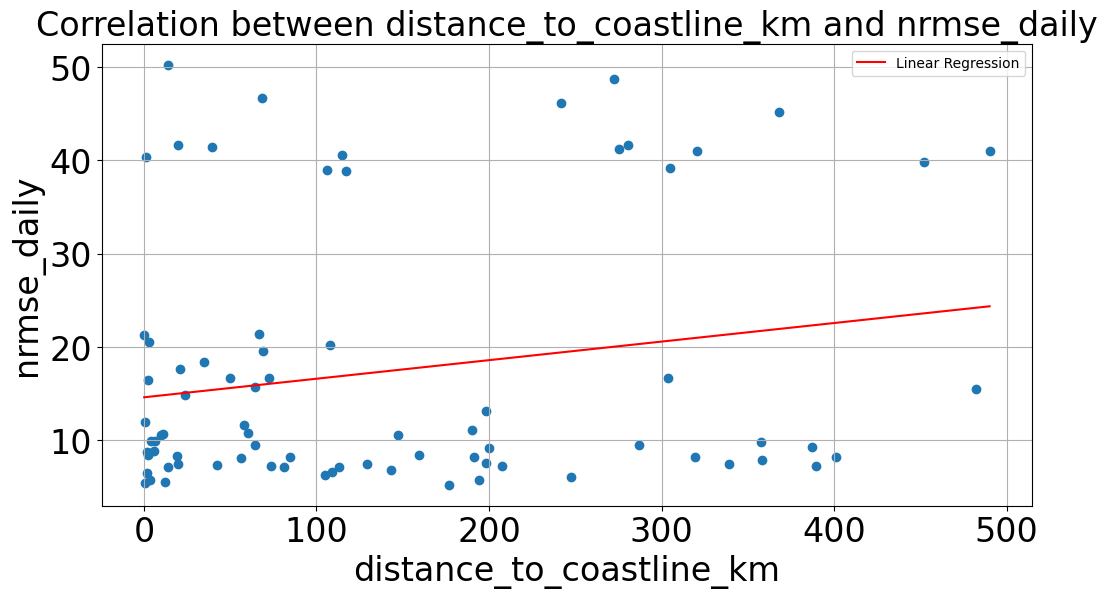

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


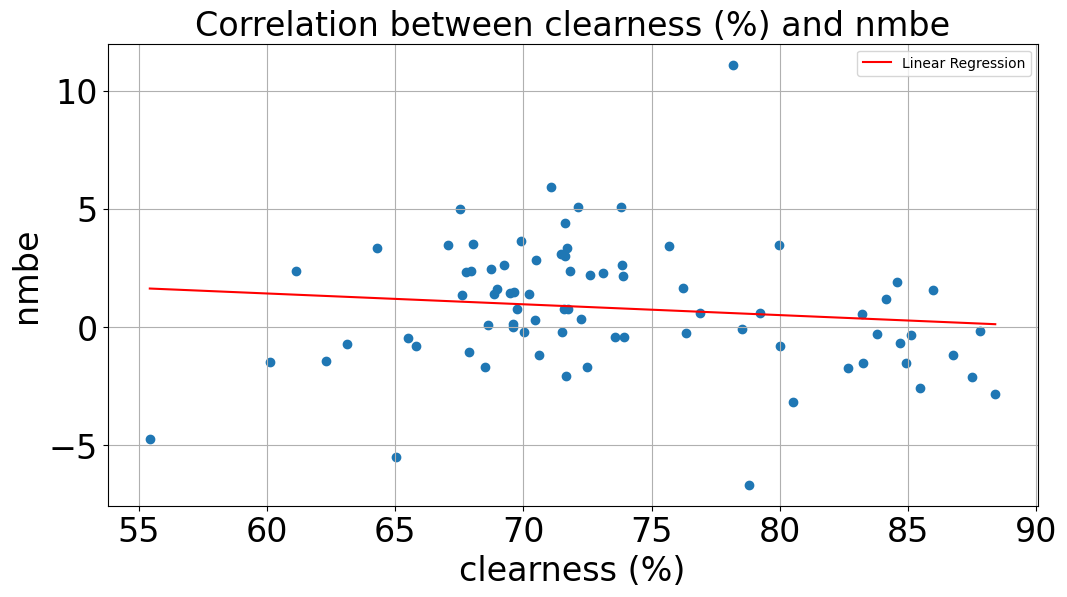

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


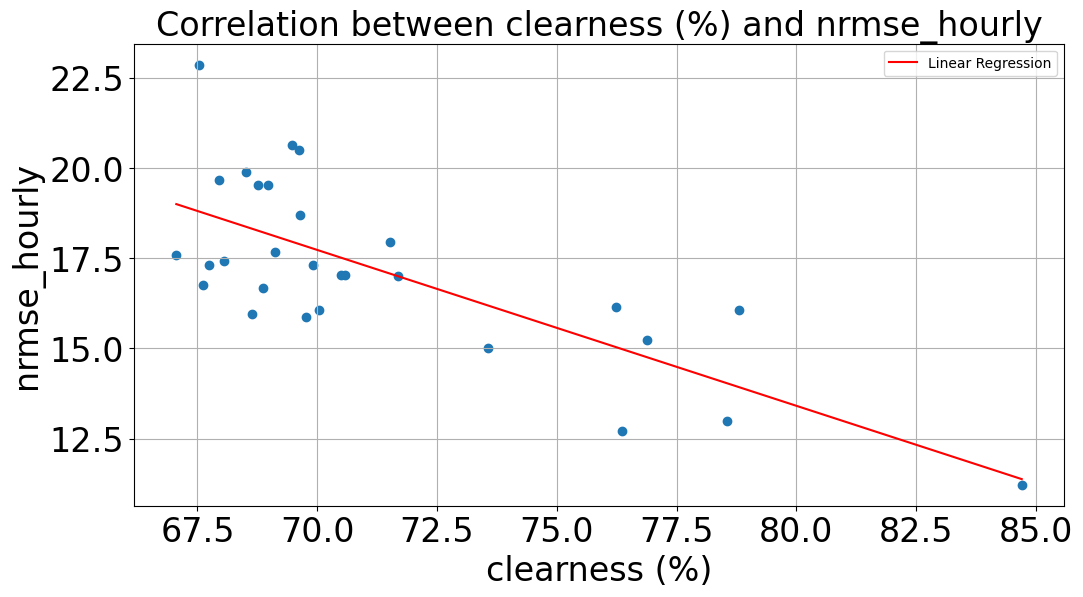

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


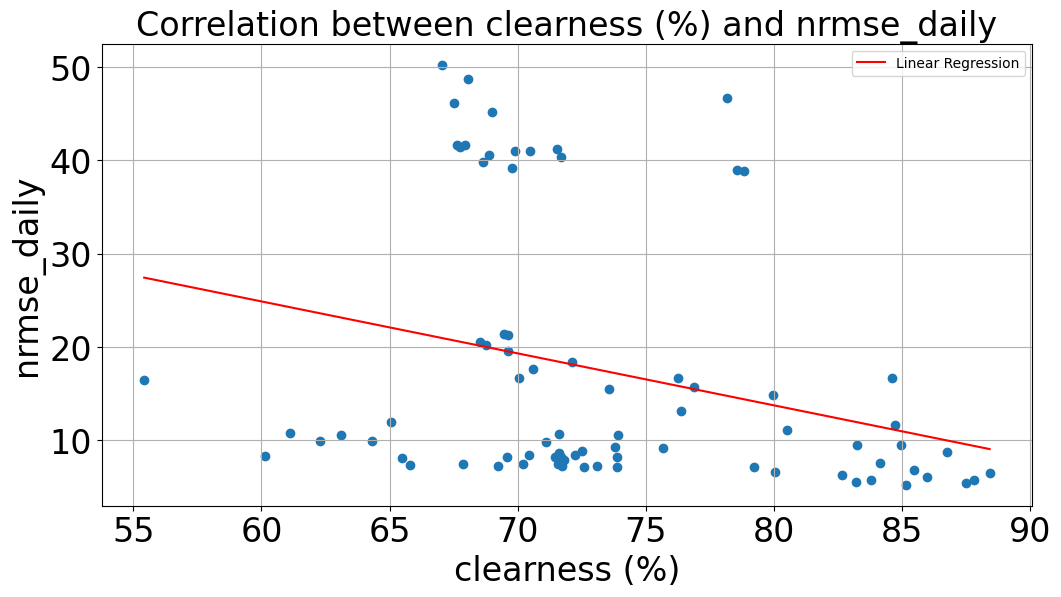

In [24]:
for complexity_name in continuous_list:
    for metric_name in metric_list:
        continuous_scatter(complexity, validation_metrics, complexity_name, metric_name)

# Box plot

In [70]:
def categorical_box(df_complexity, df_validation, complexity_name, metric_name, x_order=None, x_ticklabels=None):
    # merge df
    merged_df = pd.merge(df_complexity, df_validation, on='station_name')
            
    # outlier
    ## detect
    z_scores = (merged_df[metric_name] - merged_df[metric_name].mean()) / merged_df[metric_name].std()
    outlier_indices = merged_df[z_scores >= 3].index
    print("Indices of outliers:", outlier_indices)
    
    ## delete
    merged_df = merged_df[(z_scores < 3)]
    
    # plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=complexity_name, y=metric_name, data=merged_df, order=x_order)
    
    if x_ticklabels:
        plt.xticks(range(len(x_ticklabels)), x_ticklabels)
        
    plt.title(f'Correlation between {complexity_name} and {metric_name}', fontsize = 20)
    plt.xlabel(complexity_name, fontsize = 20)
    plt.ylabel(metric_name, fontsize = 20)
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', labelsize = 20)
    plt.tick_params(axis='y', labelsize = 20)    
    
    plt.grid(True)
    
    # plt.savefig(os.path.join(plots_path, f'{complexity_name}_{metric_name}.png'), dpi=300)
    
    plt.show()


Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


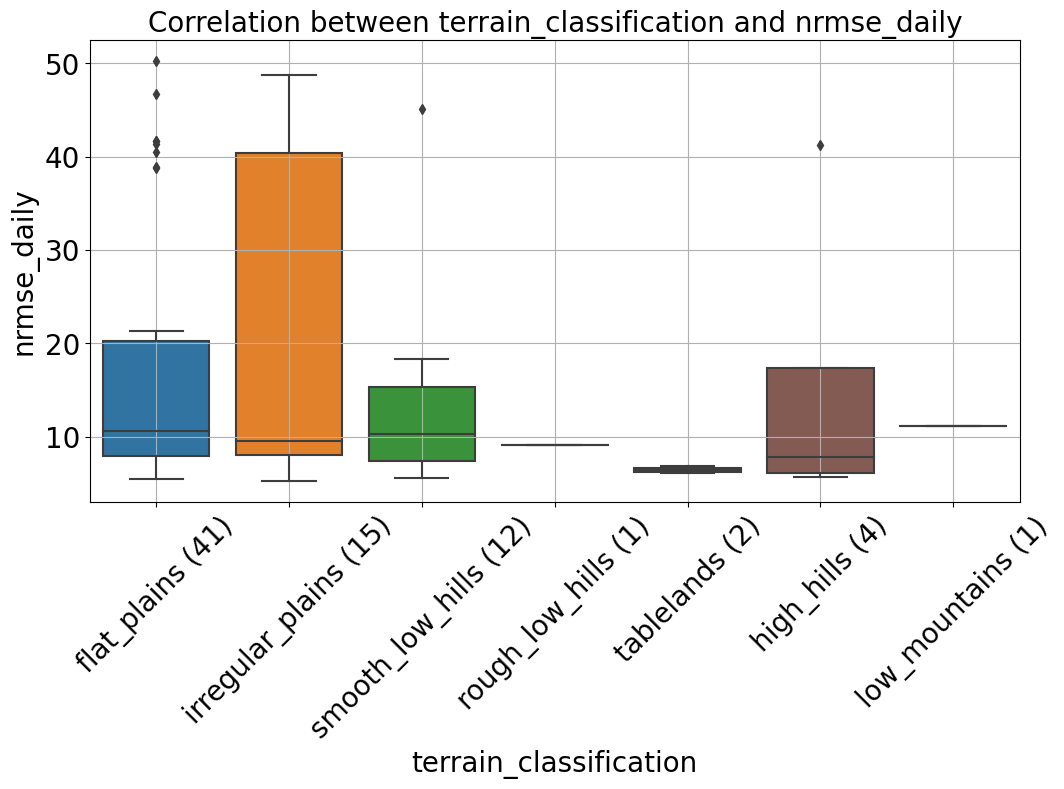

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


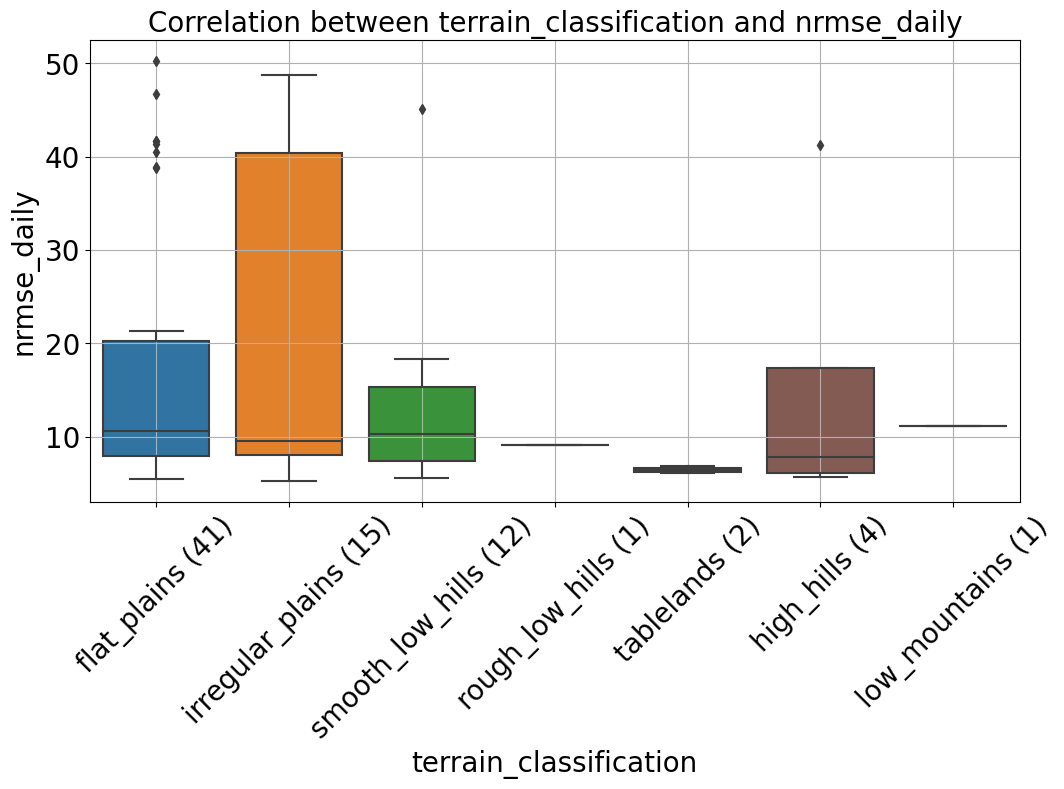

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


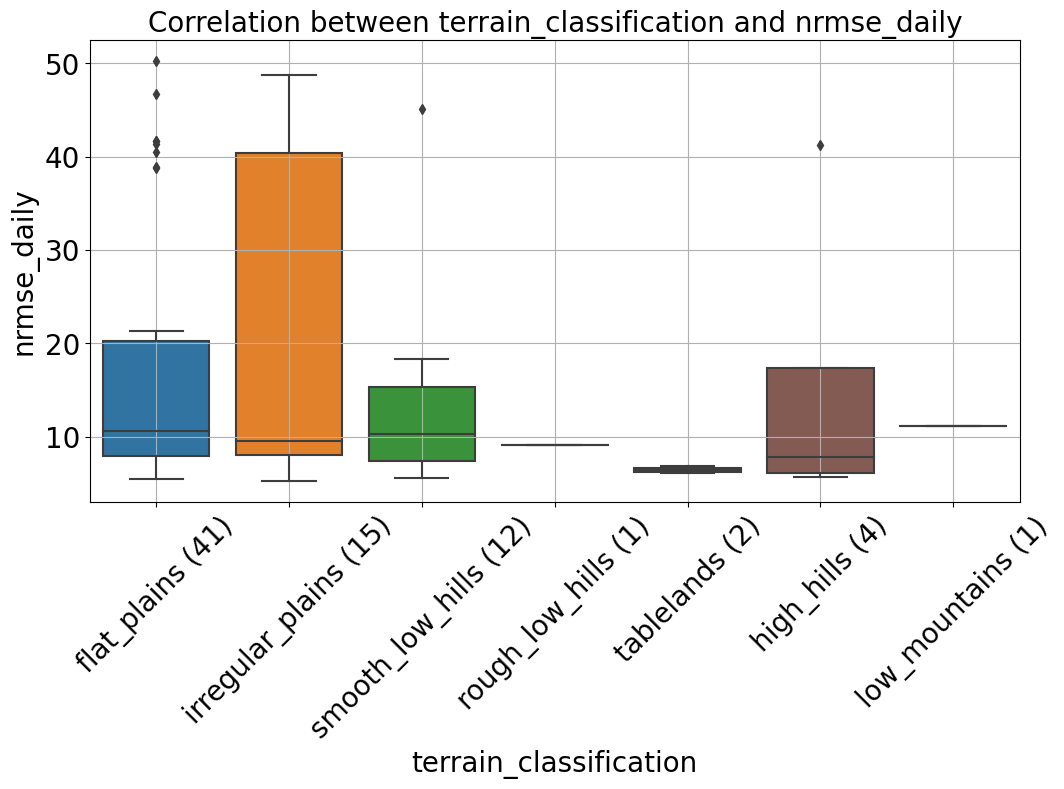

In [73]:
for metric_name in metric_list:
    categorical_box(complexity, validation_metrics, 'terrain_classification', 'nrmse_daily', 
                    x_order=['_flat plains', '_irregular plains', '_smooth low hills', '_rough low hills', '_tablelands', '_high hills', '_low mountains'],
                    x_ticklabels=['flat_plains (41)', 'irregular_plains (15)', 'smooth_low_hills (12)', 'rough_low_hills (1)', 'tablelands (2)', 'high_hills (4)', 'low_mountains (1)'])

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


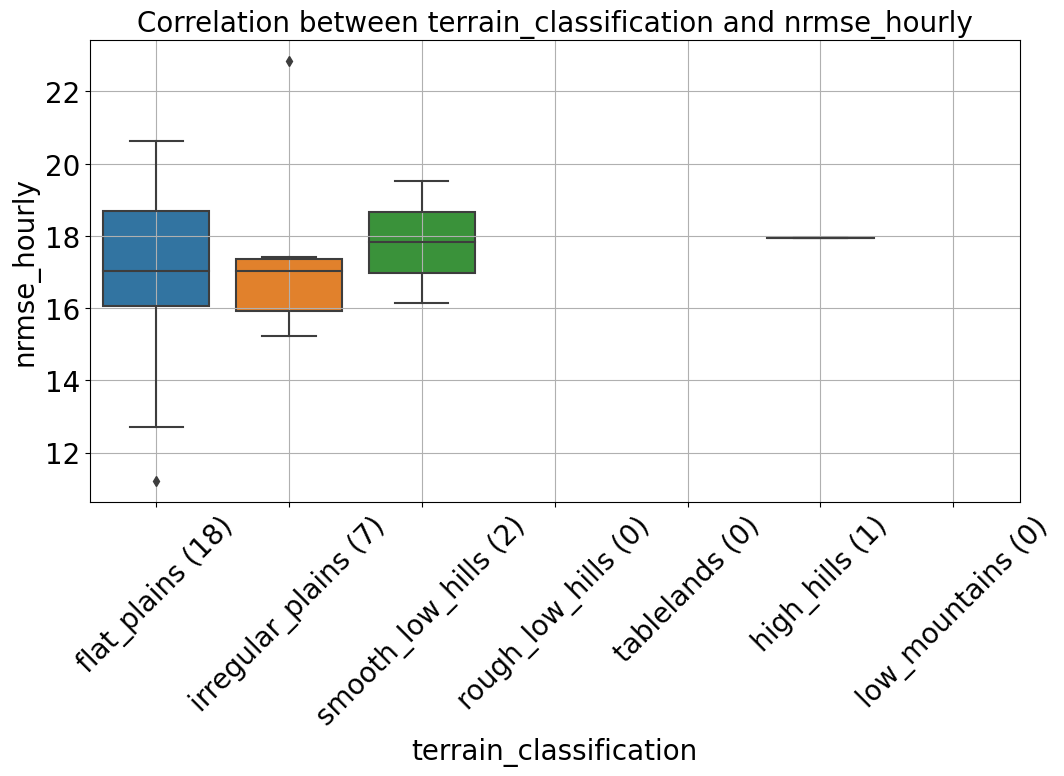

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


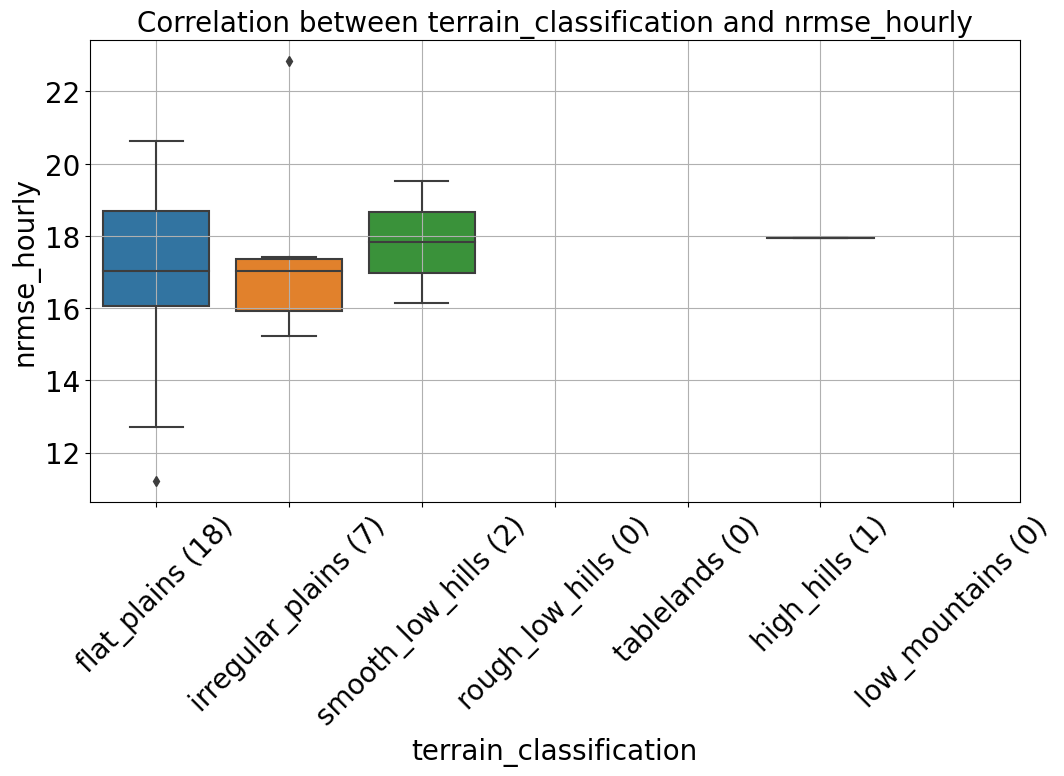

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


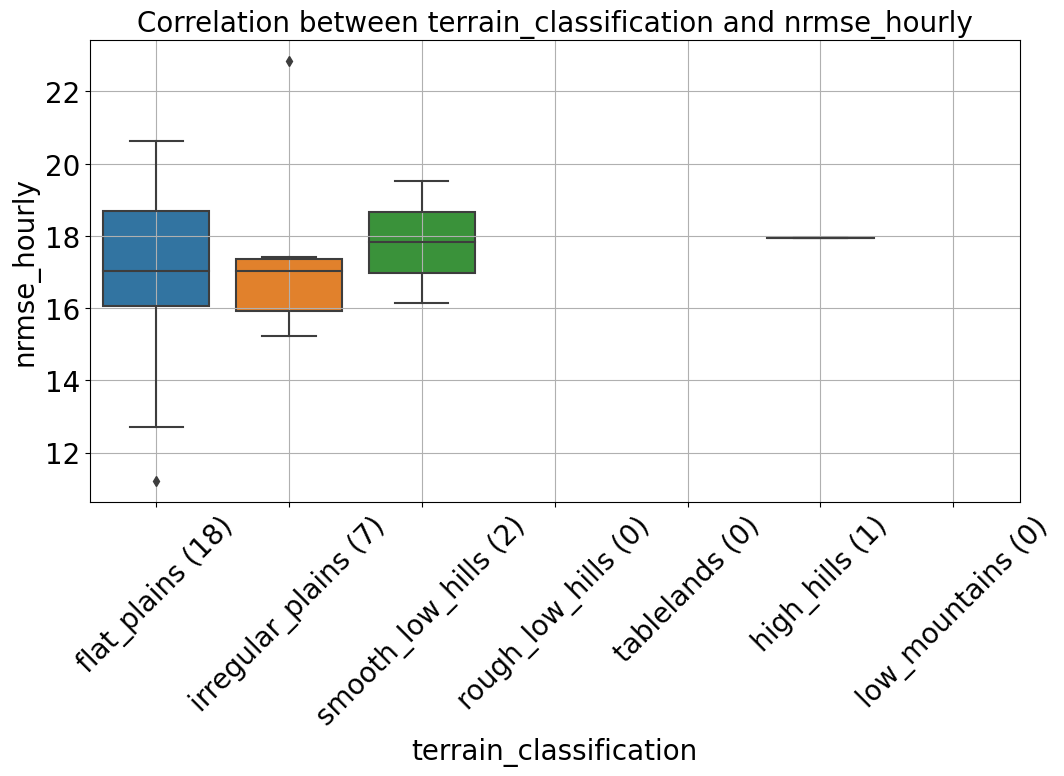

In [75]:
for metric_name in metric_list:
    categorical_box(complexity, validation_metrics, 'terrain_classification', 'nrmse_hourly', 
                    x_order=['_flat plains', '_irregular plains', '_smooth low hills', '_rough low hills', '_tablelands', '_high hills', '_low mountains'],
                    x_ticklabels=['flat_plains (18)', 'irregular_plains (7)', 'smooth_low_hills (2)', 'rough_low_hills (0)', 'tablelands (0)', 'high_hills (1)', 'low_mountains (0)'])

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


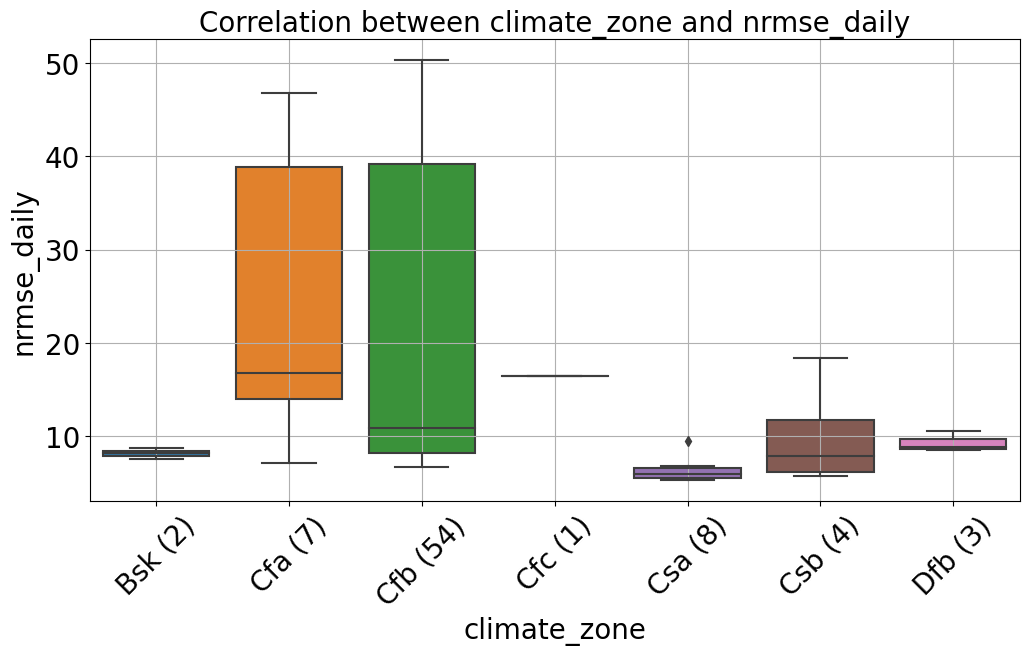

In [100]:
categorical_box(complexity, validation_metrics, 'climate_zone', 'nrmse_daily', 
                x_order=['BSk', 'Cfa', 'Cfb', 'Cfc', 'Csa', 'Csb', 'Dfb'],
                x_ticklabels=['Bsk (2)', 'Cfa (7)', 'Cfb (54)', 'Cfc (1)', 'Csa (8)', 'Csb (4)', 'Dfb (3)'])

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


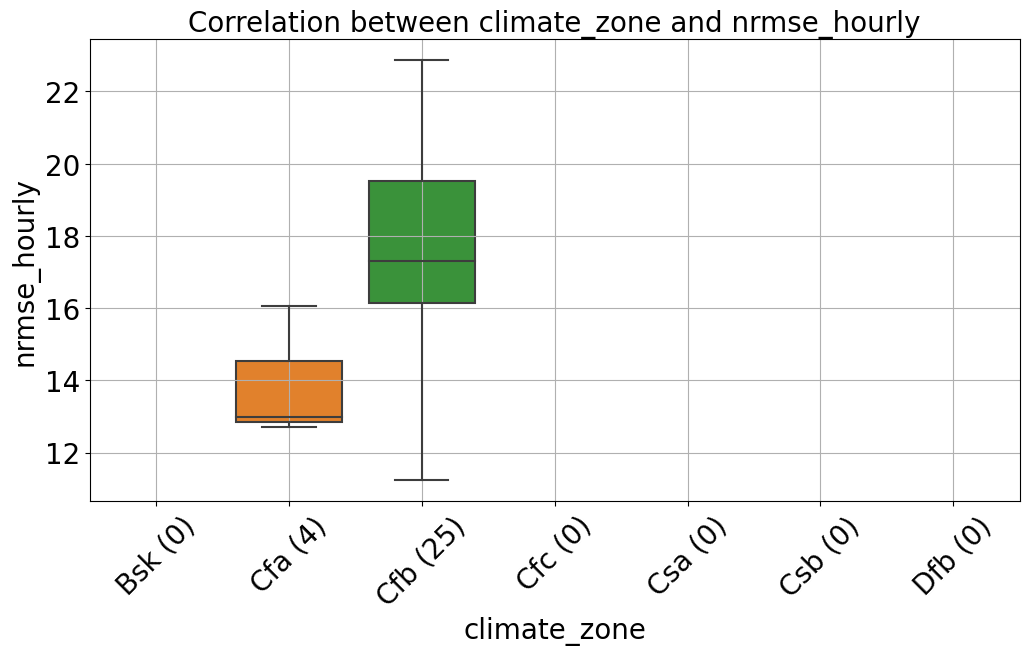

In [98]:
categorical_box(complexity, validation_metrics, 'climate_zone', 'nrmse_hourly', 
                x_order=['Bsk', 'Cfa', 'Cfb', 'Cfc', 'Csa', 'Csb', 'Dfb'],
                x_ticklabels=['Bsk (0)', 'Cfa (4)', 'Cfb (25)', 'Cfc (0)', 'Csa (0)', 'Csb (0)', 'Dfb (0)'])

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


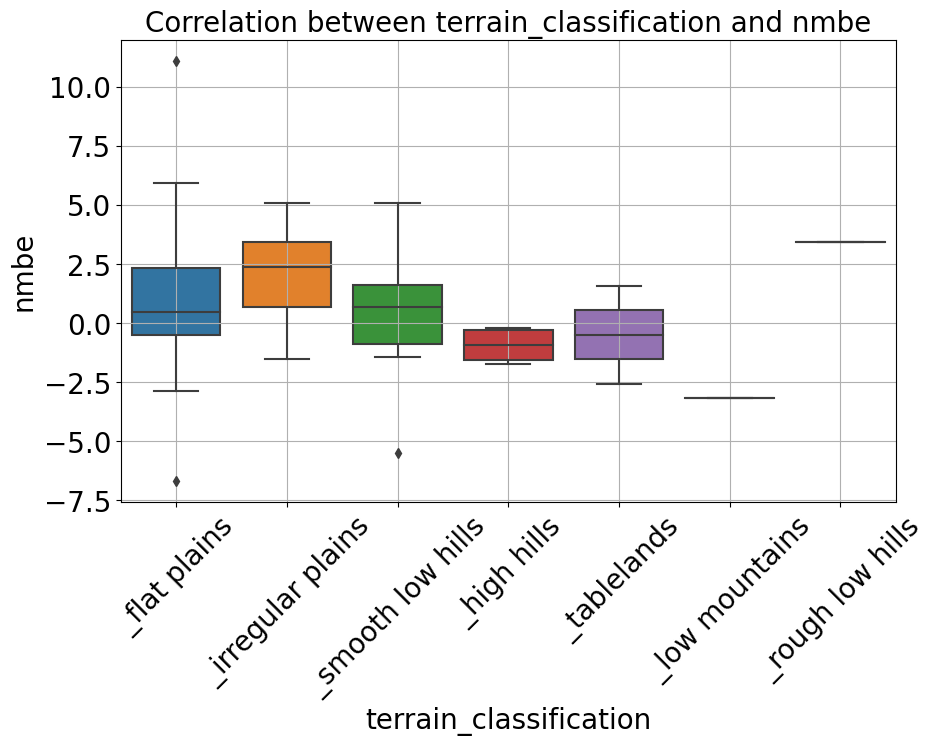

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


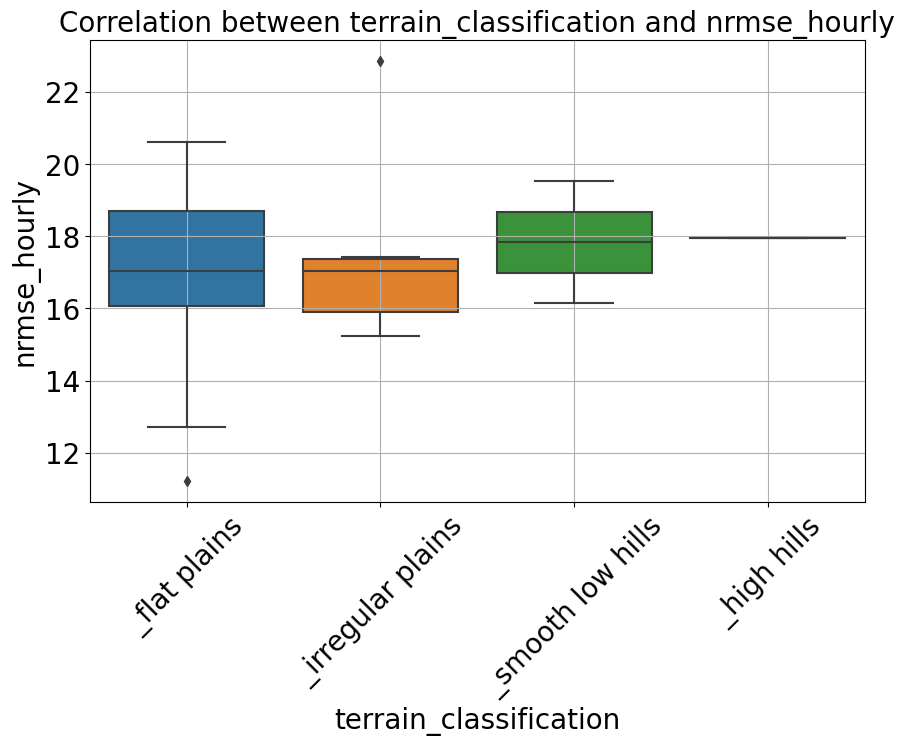

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


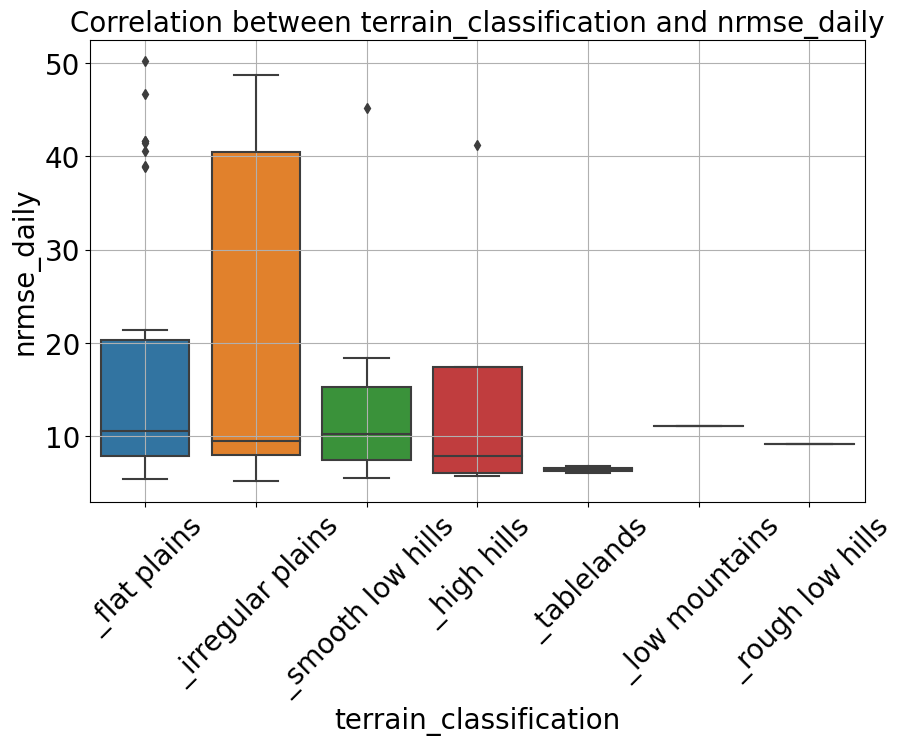

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


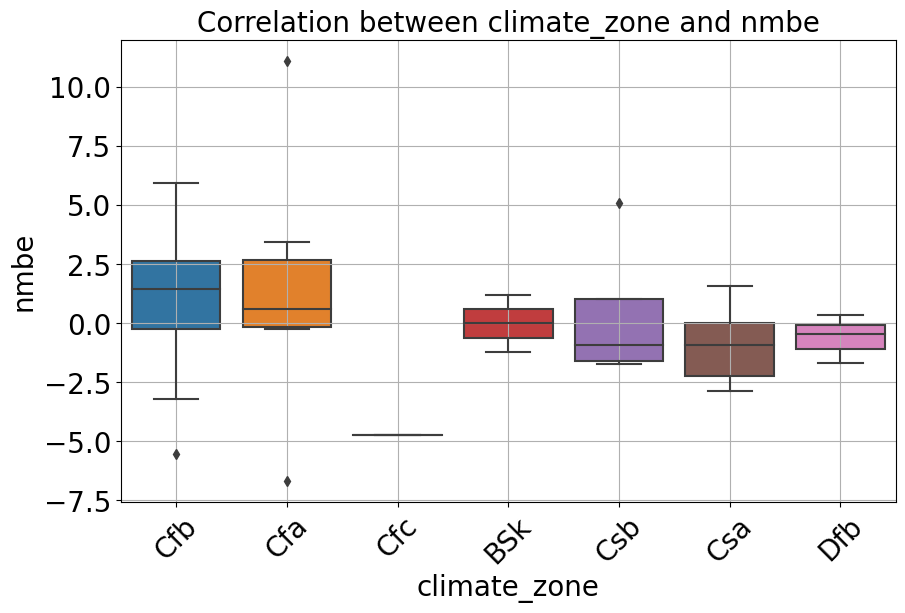

Indices of outliers: Index(['cornale'], dtype='object', name='station_name')


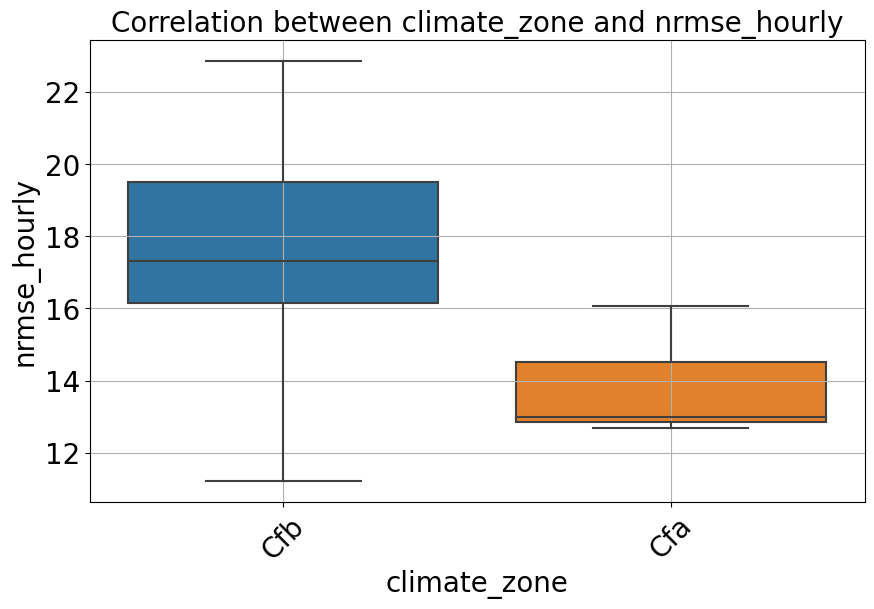

Indices of outliers: Index(['mannheim'], dtype='object', name='station_name')


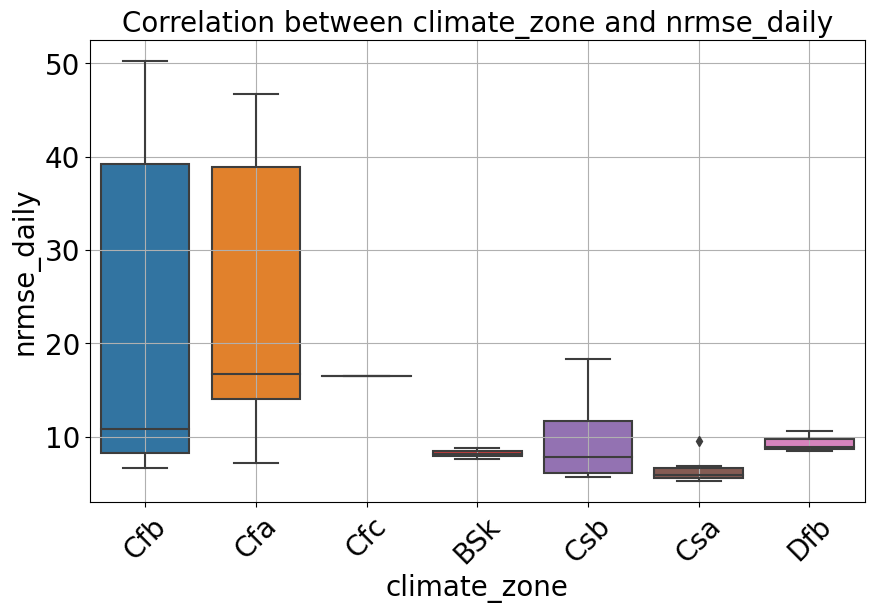

In [33]:
for complexity_name in categorical_list:
    for metric_name in metric_list:
        categorical_box(complexity, validation_metrics, complexity_name, metric_name)